In [10]:
# Annie Polish, 2022
# This notebook produces the plots used in the RFI section of the drone paper

import numpy as np
import pandas as pd

# %matplotlib widget
# import matplotlib.animation as animation
# import plotly.express as px
# import plotly.graph_objects as go

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import csv
import h5py,glob
plt.rcParams.update({'font.size': 16})
from math import *



In [2]:
def VNAtranslator(allscans, rows_to_cut=51):
    freqs = []
    mags = []
    for i in range(len(allscans)):
        data = []
        with open(allscans[i], 'rt') as f:
            reader = csv.reader(f)
            for row in reader:
                data.append(row)
        data_np = np.array(data)
        datafinal = data_np[rows_to_cut:-1]
        df=[]
        freq1 = []
        mag1 = []
        for i in datafinal:
            freq1.append(float(i[0]))
            mag1.append(float(i[1]))   
        freqs.append(freq1)
        mags.append(mag1)
    return(freqs,mags)

def avg_spectra(spec_list):
    avg = np.zeros(len(spec_list[0]))
    for i in range(len(spec_list[0])):
        for j in range(len(spec_list)):
            avg[i] += (10.**(spec_list[j][i]/10.))
        avg[i] = avg[i]/len(spec_list)
        avg[i] = 10.*np.log10(avg[i])        
    return np.array(avg)

make some dictionaries for iterating through data
also join up all the spectra from the high-band tests

Chamber:
 - horizontal by angle
 - vertical by angle
 - yaw by angle
 - shielding
 - motors 
   - and laptop background
 - noise source on
   - drone on/off
   - antenna polarization
 - long-term yaw 0 test
 
Outdoor:
 - for each antenna and polarization:
   - background
   - motors off
   - spinning but landed
   - hover and spin
 
`chamber[hi/low][bgnd/horiz/vert/yaw/shield/motor/laptop/long][angles, indices, etc]`

`outdoor[yagi/wfil/wunfil][E/H/vert][bgnd/nomotor/landed/hovering]`

# Load in data

In [3]:
# Load in all the RFI chamber data and put it in a nice dictionary

fileset='/hirax/GBO_Oct_2021/RFIChamber/*.csv'

allscans=np.sort(glob.glob(fileset))
freqs,mags=VNAtranslator(allscans = allscans, rows_to_cut=1)

for i in range(len(freqs)):
    freqs[i] = np.array(freqs[i])#/1000000000.
    mags[i] = np.array(mags[i])
    #print(str(i)+": "+allscans[i])

# build the EMI chamber dictionary
chamber = {
    "low":{
        "bgnd":None,
        "horiz":{},
        "vert":{},
        "yaw":{},
        "shield":None,
        "laptop":{},
        "motor":{},
        "nsonly":{},
        "nsdrone":{},
        "long":[],
        "freqs":None
    },
    "high":{
        "bgnd":None,
        "horiz":{},
        "vert":{},
        "yaw":{},
        "shield":None,
        "laptop":None,
        "motor":None,
        "freqs":None
    }
}

used = []
# start by making the low-band version
for i, fname in enumerate(allscans):
    if "20M1G.csv" in fname:
#         print(fname)
        if "QR" in fname:
            chamber["low"]["freqs"] = freqs[i]; used.append(i)
            chamber["low"]["bgnd"] = mags[i]
        if "DroneOnHoriz" in fname:
            angle = int(fname.split('/')[-1][12])
            if angle == 0: chamber["low"]["horiz"]["0"] = mags[i]; used.append(i)
            if angle == 1: chamber["low"]["horiz"]["180"] = mags[i]; used.append(i)
            if angle == 2: chamber["low"]["horiz"]["270"] = mags[i]; used.append(i)
            if angle == 9: chamber["low"]["horiz"]["90"] = mags[i]; used.append(i)
        if "Yaw" in fname and not ("ShieldedPS" in fname):
            angle = int(fname.split('/')[-1][10])
            if angle == 0: chamber["low"]["yaw"]["0"] = mags[i]; used.append(i)
            if angle == 6: chamber["low"]["yaw"]["60"] = mags[i]; used.append(i)
            if angle == 1: chamber["low"]["yaw"]["120"] = mags[i]; used.append(i)
        if "DroneOffNoiseOn" in fname:
            if "Horiz" in fname and "CoPol" in fname: chamber["low"]["nsonly"]["coh"] = mags[i]; used.append(i)
            if "Horiz" in fname and "XPol" in fname: chamber["low"]["nsonly"]["xh"] = mags[i]; used.append(i)
            if "Vert" in fname and "CoPol" in fname: chamber["low"]["nsonly"]["cov"] = mags[i]; used.append(i)
            if "Vert" in fname and "XPol" in fname: chamber["low"]["nsonly"]["xv"] = mags[i]; used.append(i)
        if "DroneOnNoiseOn" in fname:
            if "Horiz" in fname and "CoPol" in fname: chamber["low"]["nsdrone"]["coh"] = mags[i]; used.append(i)
            if "Horiz" in fname and "XPol" in fname: chamber["low"]["nsdrone"]["xh"] = mags[i]; used.append(i)
            if "Vert" in fname and "CoPol" in fname: chamber["low"]["nsdrone"]["cov"] = mags[i]; used.append(i)
            if "Vert" in fname and "XPol" in fname: chamber["low"]["nsdrone"]["xv"] = mags[i]; used.append(i)
        if "LaptopOn" in fname:
            if "RotorsOn" in fname and "HPol" in fname: chamber["low"]["motor"]["hpol"] = mags[i]; used.append(i)
            if "RotorsOn" in fname and "EPol" in fname: chamber["low"]["motor"]["epol"] = mags[i]; used.append(i)
            if not ("RotorsOn" in fname) and "HPol" in fname: chamber["low"]["laptop"]["hpol"] = mags[i]; used.append(i)
            if not ("RotorsOn" in fname) and "EPol" in fname: chamber["low"]["laptop"]["epol"] = mags[i]; used.append(i)
        if "DroneOnVert" in fname and not ("ShieldedPS" in fname):
            angle = fname.split('/')[-1][11]
            if angle != '-':
                if angle == '0': chamber["low"]["vert"]["0"] = mags[i]; used.append(i)
                if angle == '1': chamber["low"]["vert"]["15"] = mags[i]; used.append(i)
                if angle == '3': chamber["low"]["vert"]["30"] = mags[i]; used.append(i)
                if angle == '4': chamber["low"]["vert"]["45"] = mags[i]; used.append(i)
                if angle == '6': chamber["low"]["vert"]["60"] = mags[i]; used.append(i)
                if angle == '9': chamber["low"]["vert"]["90"] = mags[i]; used.append(i)
            else:
                angle = fname.split('/')[-1][12]
                if angle == '3': chamber["low"]["vert"]["-30"] = mags[i]; used.append(i)
                if angle == '4': chamber["low"]["vert"]["-45"] = mags[i]; used.append(i)
                if angle == '6': chamber["low"]["vert"]["-60"] = mags[i]; used.append(i)
                if angle == '9': chamber["low"]["vert"]["-90"] = mags[i]; used.append(i)
                if angle == '1' and fname.split('/')[-1][13] == '5': chamber["low"]["vert"]["-15"] = mags[i]; used.append(i)
                if angle == '1' and fname.split('/')[-1][13] == '8': chamber["low"]["vert"]["180"] = mags[i]; used.append(i)
        if "ShieldedPS" in fname:
            chamber["low"]["shield"] = mags[i]; used.append(i)

low_bgnds = []
            
for i, fname in enumerate(allscans):
    if "EPol20M1G_" in fname:
        chamber["low"]["long"].append(mags[i])
        print(fname)
    if "QR20M1G" in fname:
        low_bgnds.append(mags[i])
        print(fname)

# then join up the high-band spectra
# find all the unique spectra
hi_unique = []
for i, fname in enumerate(allscans):
    if "1G2G.csv" in fname:
        hi_unique.append(fname)

# join each spectrum into one big spectrum
joined_freqs = []
joined_mags = []
joined_basenames = []
for fname in hi_unique:
    basename = fname.split('/')[-1].split('G')[0][:-1]
    joined_basenames.append(basename)
    
    freqs12=[]; freqs24=[]; freqs46=[]; freqs68=[]; freqs810=[]; freqs1012=[]
    mags12=[]; mags24=[]; mags46=[]; mags68=[]; mags810=[]; mags1012=[]
    for i, fname in enumerate(allscans):
        if basename in fname:
            if "1G2G" in fname: mags12 = mags[i]; freqs12 = freqs[i]
            if "2G4G" in fname: mags24 = mags[i]; freqs24 = freqs[i]
            if "4G6G" in fname: mags46 = mags[i]; freqs46 = freqs[i]
            if "6G8G" in fname: mags68 = mags[i]; freqs68 = freqs[i]
            if "8G10G" in fname: mags810 = mags[i]; freqs810 = freqs[i]
            if "10G12G" in fname: mags1012 = mags[i]; freqs1012 = freqs[i]
                
    joined_freqs.append(np.concatenate((freqs12, freqs24, freqs46, freqs68, freqs810, freqs1012)))
    joined_mags.append(np.concatenate((mags12, mags24, mags46, mags68, mags810, mags1012)))

# then assign each spectrum into the dictionary
for i, basename in enumerate(joined_basenames):
    if "QR" in basename: chamber["high"]["bgnd"] = joined_mags[i]
    if "Horiz0" in basename: chamber["high"]["horiz"]["0"] = joined_mags[i]
    if "Horiz90" in basename: chamber["high"]["horiz"]["90"] = joined_mags[i]
    if "LaptopOnHoriz" in basename: chamber["high"]["laptop"] = joined_mags[i]
    if "LaptopOnRotors" in basename: chamber["high"]["motor"] = joined_mags[i]
    if "Vert-0deg" in basename: chamber["high"]["vert"]["0"] = joined_mags[i]
    if "Vert-180deg" in basename: chamber["high"]["vert"]["180"] = joined_mags[i]
    if "Vert-90deg" in basename: chamber["high"]["vert"]["-90"] = joined_mags[i]
    if "Vert90deg" in basename: chamber["high"]["vert"]["90"] = joined_mags[i]
    if "Yaw0deg" in basename and not ("Shielded" in basename): chamber["high"]["yaw"]["0"] = joined_mags[i]
    if "Yaw60deg" in basename: chamber["high"]["yaw"]["60"] = joined_mags[i]
    if "Yaw120deg" in basename: chamber["high"]["yaw"]["120"] = joined_mags[i]
    if "ShieldedPS" in basename: chamber["high"]["shield"] = joined_mags[i]

    
chamber["high"]["freqs"] = joined_freqs[0] # only need one freqs array


/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_02.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_03.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_04.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_05.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_06.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_07.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_08.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_09.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_10.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_11.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_12.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_13.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_14.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_15.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G_16.csv
/hirax/GBO_Oct_2021/RFIChamber/DroneOnVert0degEPol20M1G

In [4]:
# Load in all the outdoor data and put it in a nice dictionary
fileset='/hirax/GBO_Oct_2021/spec_an_data/FPH/outdoor_rfi/*.csv'

allscans=np.sort(glob.glob(fileset))
freqs,mags=VNAtranslator(allscans = allscans, rows_to_cut=51)

for i in range(len(freqs)):
    freqs[i] = np.array(freqs[i])/1000000.
    mags[i] = np.array(mags[i])
    #print(str(i)+": "+allscans[i])
    
outdoor = {
    "yagi":{
        "freqs":None,
        "bgnd":{},
        "motorsoff":{},
        "motorson":{},
        "hover":{}
    },
    "wfil":{
        "freqs":None,
        "bgnd":{},
        "motorsoff":{},
        "motorson":{},
        "hover":{}    
    },
    "wunfil":{
        "freqs":None,
        "bgnd":{},
        "motorsoff":{},
        "motorson":{},
        "hover":{}
    }
}

for i, fname in enumerate(allscans):
    ant_name = fname.split('/')[-1].split('-')[0].split('2')[0]
    if "002" in fname or "014" in fname: outdoor[ant_name]["bgnd"]["e"] = mags[i]; outdoor[ant_name]["freqs"] = freqs[i];
    if "004" in fname or "015" in fname: outdoor[ant_name]["bgnd"]["h"] = mags[i]
    if "005" in fname: outdoor[ant_name]["motorsoff"]["h"] = mags[i]
    if "006" in fname: outdoor[ant_name]["motorson"]["h"] = mags[i]
    if "007" in fname: outdoor[ant_name]["hover"]["h"] = mags[i]
    if "008" in fname: outdoor[ant_name]["motorsoff"]["e"] = mags[i]
    if "009" in fname: outdoor[ant_name]["motorson"]["e"] = mags[i]
    if "010" in fname: outdoor[ant_name]["hover"]["e"] = mags[i]
    if "011" in fname: outdoor[ant_name]["hover"]["v"] = mags[i]
    if "013" in fname: outdoor[ant_name]["bgnd"]["v"] = mags[i]
        
        

# load in the weird test data
fileset='/hirax/GBO_Oct_2021/spec_an_data/FPH/*.csv'

allscans=np.sort(glob.glob(fileset))
freqs,mags=VNAtranslator(allscans = allscans, rows_to_cut=51)

for i in range(len(freqs)):
    freqs[i] = np.array(freqs[i])/1000000.
    mags[i] = np.array(mags[i])
    #print(str(i)+": "+allscans[i])
    
wed_freqs = []; wed_mags = []; wed_fnames = []
bad_rtk_yagi = {
    "freqs": None, 
    "bgnd":{'e':None,'h':None,'v':None},
    "motorsoff_vert":{'e':None,'h':None},
    "motorsoff":{"0":{},"90":{},"180":{},"270":{}},
    "motorson":{'e':None,'h':None},
    "hover":{'e':None,'h':None,'v':None}
}
for i, fname in enumerate(allscans):
    if "yagi-" in fname:
        wed_freqs.append(freqs[i])
        wed_mags.append(mags[i])
        wed_fnames.append(fname.split('/')[-1])
        
for i in range(len(wed_fnames)):
    print(str(i)+": "+wed_fnames[i]+", "+str(len(wed_mags[i])))
        
bad_rtk_yagi["freqs"] = wed_freqs[0][6:]
bad_rtk_yagi["bgnd"]['e'] = wed_mags[4]
bad_rtk_yagi["bgnd"]['h'] = wed_mags[6]
bad_rtk_yagi["bgnd"]['v'] = wed_mags[2]
bad_rtk_yagi["motorsoff_vert"]['e'] = wed_mags[9][6:]
bad_rtk_yagi["motorsoff_vert"]['h'] = wed_mags[11][6:]
bad_rtk_yagi["motorsoff"]["0"]["e"] = wed_mags[16][6:]
bad_rtk_yagi["motorsoff"]["90"]["e"] = wed_mags[17]
bad_rtk_yagi["motorsoff"]["180"]["e"] = wed_mags[18]
bad_rtk_yagi["motorsoff"]["270"]["e"] = wed_mags[19]
bad_rtk_yagi["motorsoff"]["0"]["h"] = wed_mags[12][6:]
bad_rtk_yagi["motorsoff"]["90"]["h"] = wed_mags[13][6:]
bad_rtk_yagi["motorsoff"]["180"]["h"] = wed_mags[14][6:]
bad_rtk_yagi["motorsoff"]["270"]["h"] = wed_mags[15][6:]
bad_rtk_yagi["motorson"]["e"] = wed_mags[20]
bad_rtk_yagi["motorson"]["h"] = wed_mags[21]
bad_rtk_yagi["hover"]["e"] = wed_mags[23]
bad_rtk_yagi["hover"]["h"] = wed_mags[22]
bad_rtk_yagi["hover"]["v"] = wed_mags[24]


0: yagi-bgnd001.csv, 705
1: yagi-bgnd002.csv, 705
2: yagi-bgnd003.csv, 699
3: yagi-bgnd004.csv, 699
4: yagi-bgnd005.csv, 699
5: yagi-bgnd006.csv, 699
6: yagi-bgnd007.csv, 699
7: yagi-bgnd008.csv, 699
8: yagi-rfi001.csv, 705
9: yagi-rfi002.csv, 705
10: yagi-rfi003.csv, 705
11: yagi-rfi004.csv, 705
12: yagi-rfi005.csv, 705
13: yagi-rfi006.csv, 705
14: yagi-rfi007.csv, 705
15: yagi-rfi008.csv, 705
16: yagi-rfi009.csv, 705
17: yagi-rfi010.csv, 699
18: yagi-rfi011.csv, 699
19: yagi-rfi012.csv, 699
20: yagi-rfi013.csv, 699
21: yagi-rfi014.csv, 699
22: yagi-rfi015.csv, 699
23: yagi-rfi016.csv, 699
24: yagi-rfi017.csv, 699


<ipython-input-2-b602bb13b2b7>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_np = np.array(data)


In [5]:
# load the old data from the RFI tests in august

fileset = "/hirax/rf_data/GBO_specan_data/RFI/SOE_20210826_134958/*"
allscans=np.sort(glob.glob(fileset))
freqs,mags=VNAtranslator(allscans = allscans, rows_to_cut=51)
for i in range(len(freqs)):
    freqs[i] = np.array(freqs[i])/1000000.
    mags[i] = np.array(mags[i])
    
    
# hovernear means 3m
# hoverfar means 10m
# polarization options are 'n' and 'e'
oldout = {
    "yagi":{
        "freqs":None,
        "bgnd":{},
        "hovernear":{},
        "hoverfar":{}
    },
    "wunfil":{
        "freqs":None,
        "bgnd":{},
        "hovernear":{},
        "hoverfar":{}
    }
}

# assign spectra to the dictionary based on what i previously did in gbo_rfi.ipynb
# just trust me im sure its fine lol
oldout["wunfil"]["freqs"] = freqs[75]
oldout["wunfil"]["bgnd"] = mags[123]
oldout["wunfil"]["hovernear"] = mags[75] 
oldout["wunfil"]["hoverfar"] = mags[98]


fileset = "/hirax/rf_data/GBO_specan_data/RFI/SOE_20210826_140543/*"
allscans=np.sort(glob.glob(fileset))
freqs,mags=VNAtranslator(allscans = allscans, rows_to_cut=51)
for i in range(len(freqs)):
    freqs[i] = np.array(freqs[i])/1000000.
    mags[i] = np.array(mags[i])

oldout["yagi"]["freqs"] = freqs[71]
oldout["yagi"]["bgnd"] = mags[71]
oldout["yagi"]["hovernear"]['n'] = mags[35]
oldout["yagi"]["hovernear"]['e'] = mags[26]
oldout["yagi"]["hoverfar"]['n'] = mags[46]
oldout["yagi"]["hoverfar"]['e'] = mags[54]

<ipython-input-2-b602bb13b2b7>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_np = np.array(data)


## Load cage data

In [6]:
# load in the data from post-trip tests in our lab faraday cage
fileset="/hirax/rf_data/yale_drone_testing/winter_21_mitigation/*.csv"
allscans=np.sort(glob.glob(fileset))
freqs,mags=VNAtranslator(allscans = allscans, rows_to_cut=51)
for i in range(len(freqs)):
    freqs[i] = np.array(freqs[i])/1000000.
    mags[i] = np.array(mags[i])
    
lab_freqs = freqs[0]
lab_bgnd = []; lab_cycle1 = []; lab_cycle3 = []; lab_cycle4 = [];
cycle1_freqs = None; cycle3_freqs = None; cycle4_freqs = [];

cage_response_freqs= None;
cage_response_mags = []

tee_freqs = []; tee_mags = []

cage_s12_freqs = []; cage_s12_mags = []

for i, fname in enumerate(allscans):
    if "bgnd" in fname:
        lab_bgnd.append(mags[i])
    if "cycle1" in fname:
        lab_cycle1.append(mags[i])
        cycle1_freqs = freqs[i]
    if "cycle3" in fname:
        lab_cycle3.append(mags[i])
        cycle3_freqs = freqs[i]
    if "cycle4" in fname:
        lab_cycle4.append(mags[i])
        cycle4_freqs = freqs[i]
    if "bicolog-cage" in fname:
        cage_response_mags.append(mags[i])
        cage_response_freqs = freqs[i]
    if "tee-testing" in fname:
        tee_freqs.append(freqs[i])
        tee_mags.append(mags[i])
    if "cage-s12" in fname:
        cage_s12_freqs.append(freqs[i])
        cage_s12_mags.append(mags[i])
        
# load the zero-span data 
fileset="/hirax/rf_data/yale_drone_testing/202112_mitigation/zero_span/*.csv"
allscans=np.sort(glob.glob(fileset))
freqs,mags=VNAtranslator(allscans = allscans, rows_to_cut=45)
    
zerospan_ts = {"107":None, "180":None, "193":None, "278":None, "439_short":None, "439_long":None} 
zerospan_mags = {"107":None, "180":None, "193":None, "278":None, "439_short":None, "439_long":None} 

for i, fname in enumerate(allscans):
    if "2-005" in fname:
        zerospan_ts["107"] = freqs[i]
        zerospan_mags["107"] = mags[i]
    if "2-009" in fname:
        zerospan_ts["180"] = freqs[i]
        zerospan_mags["180"] = mags[i]
    if "2-010" in fname:
        zerospan_ts["193"] = freqs[i]
        zerospan_mags["193"] = mags[i]
    if "2-011" in fname:
        zerospan_ts["278"] = freqs[i]
        zerospan_mags["278"] = mags[i]
    if "2-008" in fname:
        zerospan_ts["439_short"] = freqs[i]
        zerospan_mags["439_short"] = mags[i]
    if "2-007" in fname:
        zerospan_ts["439_long"] = freqs[i]
        zerospan_mags["439_long"] = mags[i]

<ipython-input-2-b602bb13b2b7>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_np = np.array(data)


# Define correction curves

In [7]:
# define all the correction curves 

###########################
# newburgh lab equipment: #
###########################

# ZX60-43-S+ gain curve
zx60_43_freqs = [0.5,0.7,1,10,100,300,500,700,800,805,1000,1200,1400,1600,1800,2000,2200,2400,2600,2800,3000,3200,3400,3600,3800,4000]
zx60_43_mags = [22.79,22.92,23.01,23.25,23.06,23.03,23.11,22.62,22.32,22.31,21.69,21.04,20.40,19.79,19.20,18.66,18.15,17.66,17.20,16.75,16.29,15.88,15.47,15.07,14.69,14.35]

# impedance matching pad
pad_freqs = [10,50,100,150,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700]
pad_mags = [5.75,5.77,5.78,5.79,5.8,5.83,5.84,5.85,5.86,5.87,5.87,5.88,5.88,5.89,5.89,5.9,5.9,5.9,5.9,5.9]

# hi-pass filter
vhf_1080_freqs = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,802,807,810,812,817,820,822,827,830,832,837,840,842,847,850,852,857,860,862,867,870,872,877,880,882,887,890,892,897,900,902,907,910,912,917,920,922,927,930,932,937,940,942,947,950,952,957,960,962,967,970,972,977,980,982,987,990,992,997,1000,1002,1007,1010,1012,1017,1020,1022,1027,1030,1032,1037,1040,1042,1047,1050,1052,1057,1060,1062,1067,1070,1072,1077,1080,1082,1087,1090,1092,1097,1100,1110,1120,1130,1140,1150,1160,1170,1180,1190,1200,1210,1220,1230,1240,1250,1260,1270,1280,1290,1300,1310,1320,1330,1340,1350,1360,1370,1380,1390,1400,1410,1420,1430,1440,1450,1460,1470,1480,1490,1500,1510,1520,1530,1540,1550,1560,1570,1580,1590,1600,1610,1620,1630,1640,1650,1660,1670,1680,1690,1700,1710,1720,1730,1740,1750,1760,1770,1780,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100,2110,2120,2130,2140,2150,2160,2170,2180,2190,2200,2210,2220,2230,2240,2250,2260,2270,2280,2290,2300,2310,2320,2330,2340,2350,2360,2370,2380,2390,2400,2410,2420,2430,2440,2450,2460,2470,2480,2490,2500,2510,2520,2530,2540,2550,2560,2570,2580,2590,2600,2610,2620,2630,2640,2650,2660,2670,2680,2690,2700,2710,2720,2730,2740,2750,2760,2770,2780,2790,2800,2810,2820,2830,2840,2850,2860,2870,2880,2890,2900,2910,2920,2930,2940,2950,2960,2970,2980,2990,3000,3010,3020,3030,3040,3050,3060,3070,3080,3090,3100,3110,3120,3130,3140,3150,3160,3170,3180,3190,3200,3210,3220,3230,3240,3250,3260,3270,3280,3290,3300,3310,3320,3330,3340,3350,3360,3370,3380,3390,3400,3410,3420,3430,3440,3450,3460,3470,3480,3490,3500,3510,3520,3530,3540,3550,3560,3570,3580,3590,3600,3610,3620,3630,3640,3650,3660,3670,3680,3690,3700,3710,3720,3730,3740,3750,3760,3770,3780,3790,3800,3810,3820,3830,3840,3850,3860,3870,3880,3890,3900,3910,3920,3930,3940,3950,3960,3970,3980,3990,4000,4010,4020,4030,4040,4050,4060,4070,4080,4090,4100]
vhf_1080_mags = [92.45234,81.23739,81.57882,78.98299,77.24767,75.18317,73.64855,73.35030,72.47469,71.33896,71.51794,70.92579,69.36712,68.95345,68.94708,68.13687,69.32429,68.48878,68.56900,67.30460,67.60728,66.78722,67.39686,66.49859,67.71653,67.48467,66.79710,68.19104,68.07624,67.96391,68.45379,69.02897,70.54659,69.72974,70.68686,72.67319,74.38254,76.07081,76.47844,78.22225,79.16872,76.76169,74.34736,71.66576,69.40736,65.69736,65.37932,63.58974,61.56538,60.13396,58.87730,57.45173,55.89385,54.72072,53.56657,52.27250,51.12350,50.15224,48.96093,47.81628,46.61587,45.59074,44.60071,43.49753,42.47839,41.46458,40.41553,39.37828,38.40092,37.38197,36.40026,35.41359,34.39097,33.40812,32.41971,31.45565,30.46148,29.47905,28.50483,27.51910,27.27456,26.78591,26.53645,26.28984,25.79930,25.56261,25.31673,24.83220,24.58596,24.34472,23.85725,23.61384,23.37550,22.87869,22.63750,22.38875,21.90607,21.66340,21.42295,20.93687,20.69513,20.45007,19.96900,19.72607,19.48389,18.99882,18.75249,18.51355,18.02615,17.78992,17.54649,17.05817,16.81938,16.57421,16.09073,15.84742,15.60845,15.12887,14.88408,14.64478,14.16395,13.92650,13.68714,13.21277,12.97213,12.73854,12.26723,12.03148,11.79788,11.33055,11.10433,10.87114,10.41338,10.18351,9.961223,9.512810,9.289762,9.074132,8.637458,8.420473,8.210784,7.791643,7.583544,7.378198,6.980887,6.784629,6.592801,6.213023,6.029306,5.849887,5.495296,5.324934,5.157285,4.834006,4.677183,4.523109,4.229650,4.091455,3.956788,3.692829,3.569535,3.449923,3.217877,3.110496,3.003640,2.807964,2.715724,2.626894,2.458019,2.380828,2.101420,1.866320,1.677215,1.521599,1.397982,1.296942,1.214193,1.148558,1.095251,1.050431,1.009086,0.977651,0.945951,0.921131,0.897954,0.874835,0.854148,0.833944,0.815071,0.798299,0.782410,0.765811,0.752027,0.737374,0.723357,0.711196,0.699254,0.688273,0.677836,0.666429,0.656922,0.647625,0.640619,0.633241,0.628023,0.620533,0.617640,0.614686,0.610852,0.609004,0.605385,0.603992,0.602555,0.600613,0.598910,0.600189,0.601181,0.602319,0.602296,0.603312,0.605107,0.604886,0.605012,0.604994,0.604942,0.605683,0.605930,0.607359,0.606072,0.606708,0.607734,0.611010,0.610802,0.611141,0.612873,0.613820,0.613562,0.613029,0.614213,0.615359,0.615054,0.615107,0.613938,0.613926,0.614134,0.610321,0.609902,0.610611,0.607241,0.605392,0.602073,0.603456,0.600732,0.597405,0.596675,0.593768,0.594532,0.590320,0.588737,0.585555,0.584505,0.579529,0.578301,0.575632,0.572590,0.569283,0.565808,0.561932,0.558361,0.554150,0.549713,0.547144,0.542906,0.541158,0.537104,0.532067,0.527633,0.524929,0.521386,0.517612,0.512189,0.508165,0.505038,0.501598,0.495363,0.492129,0.489398,0.485043,0.481777,0.476888,0.472906,0.467542,0.462307,0.458459,0.453119,0.449734,0.445874,0.442773,0.440272,0.435883,0.433679,0.430205,0.427278,0.423263,0.417836,0.414353,0.409907,0.405116,0.399072,0.397123,0.392624,0.387658,0.384470,0.381414,0.376658,0.372855,0.370932,0.368987,0.365761,0.363966,0.358866,0.352375,0.350952,0.346756,0.342347,0.340125,0.336162,0.332878,0.331345,0.327045,0.324216,0.323020,0.320169,0.316996,0.315364,0.313898,0.311322,0.310491,0.308337,0.305401,0.304268,0.302774,0.299613,0.296834,0.296544,0.293411,0.292674,0.290570,0.289607,0.289645,0.286494,0.286179,0.283523,0.282074,0.278963,0.279546,0.278730,0.277459,0.277059,0.272956,0.273596,0.273897,0.272900,0.272752,0.272992,0.272189,0.270837,0.272442,0.272452,0.272447,0.274916,0.271303,0.273470,0.273062,0.274186,0.274245,0.275362,0.277751,0.276936,0.276992,0.277302,0.277878,0.280291,0.279444,0.280789,0.282211,0.282714,0.284049,0.283855,0.285801,0.287157,0.288956,0.289226,0.293593,0.293883,0.295223,0.297537,0.298293,0.300876,0.302418,0.305304,0.307870,0.312201,0.313333,0.316174,0.316635,0.320261,0.320957,0.323682,0.326795,0.328929,0.331713,0.334982,0.338972,0.343184,0.345387,0.348964,0.353929,0.355098,0.358184,0.364113,0.368392,0.372023,0.374576,0.378735,0.382343,0.386229,0.390540,0.393921,0.399179,0.401874,0.406400,0.411359,0.416424,0.420078,0.423705,0.428230,0.432006,0.434929,0.438879,0.446206,0.450081,0.454021,0.461661,0.464537,0.469550,0.475013,0.481832,0.485106,0.491230,0.495780,0.502514,0.507341,0.511915,0.518131,0.522509,0.529142,0.535045,0.539864,0.546889,0.551150,0.559059,0.563269,0.570811,0.574528,0.583391,0.588293,0.594053,0.602027,0.608833]

# aaronia bicolog 20300 gain in dBi
bicolog_20300_freqs = [30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]
bicolog_20300_mags = [-38.73,-35.31,-32.98,-30.37,-28.36,-26.99,-25.92,-24.77,-24.00,-22.60,-21.17,-20.03,-18.96,-18.22,-17.60,-16.48,-14.51,-12.91,-11.54,-10.64,-9.61,-8.79,-7.29,-6.79,-6.41,-6.08,-4.50,-3.88,-3.37,-3.12,-1.90,-1.43,-1.48,-1.32,-0.68,-0.33,-0.20,-0.26,-0.18,0.54,0.72,0.63,0.65,0.94,1.22,1.26,0.93,0.74,0.79,0.93,0.58,0.87,0.76,0.85,0.89,0.73,0.76,0.70,0.98,0.56,0.58,0.51,0.84,0.56,0.88,0.56,1.03,0.60,0.99,0.58,0.60,0.51,0.88,0.44,0.80,0.81,1.03,0.94,0.84,0.90,0.91,1.02,0.82,0.93,0.68,1.24,1.04,1.24,1.05,1.35,1.15,1.40,1.00,1.00,1.04,1.09,1.14,1.04,1.13,1.03,1.18,1.02,0.96,0.71,0.75,-0.08,-1.61,-3.56,-5.14,-6.44,-8.21,-8.84,-9.89,-11.26,-11.09,-10.83,-10.52,-9.68,-9.35,-9.77,-10.75,-11.68,-12.03,-11.37,-10.73]

# aaronia bicolog 30100 gain in dBi
bicolog_30100_freqs = [30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,1000]
bicolog_30100_mags = [-38.73,-35.31,-32.98,-30.37,-28.36,-26.99,-25.92,-24.77,-24.00,-22.60,-21.17,-20.03,-18.96,-18.22,-17.60,-16.48,-14.51,-12.91,-11.54,-10.64,-9.61,-8.79,-7.29,-6.79,-6.41,-6.08,-4.50,-3.88,-3.37,-3.12,-1.90,-1.43,-1.48,-1.32,-0.68,-0.33,-0.20,-0.26,-0.18,0.54,0.72,0.63,0.65,0.94,1.22,1.26,0.93,0.74,0.79,0.93,0.58,0.87,0.76,0.85,0.89,0.73,0.76,0.70,0.98,0.56,0.58,0.51,0.84,0.56,0.88,0.56,1.03,0.60,0.99,0.58,0.60,0.51,0.88,0.44,0.80,0.81,1.03,0.94,0.84,0.90,0.91,1.02,0.82,0.93,0.68,1.24,1.04,1.24,1.05,1.35,1.15,1.40,1.00,1.00,1.04,1.09,1.14,1.04,1.13,1.03,1.18,1.02,0.96,0.71,0.75]

# load in the calibration data from lab
fileset='/hirax/GBO_Oct_2021/spec_an_data/post_trip/*.csv'
allscans=np.sort(glob.glob(fileset))
freqs,mags=VNAtranslator(allscans = allscans, rows_to_cut=51)
for i in range(len(freqs)): freqs[i] = np.array(freqs[i])/1000000.

# grab the S21 measurements from both the amp and the big cable
longcable_freqs = freqs[2]; longcable_mags = mags[2]
zx60_43_meas_freqs = freqs[4]; zx60_43_meas_mags = mags[4]


##################################
# carla's emi chamber equipment: #
##################################

# log periodic dipole array (low-band antenna)
lpda_freqs = [20,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600,625,650,675,700,725,750,775,800,825,850,875,900,925,950,975,1000]
lpda_mags = [-11,3.73,5.79,5.2,5.31,4.09,5.34,5.41,5.86,6.29,6.25,5.85,5.74,5.76,5.62,5.97,6.17,6.2,6.03,6.2,5.71,5.87,6.22,6.42,6.51,6.2,5.83,6.16,5.84,6.06,6.03,5.9,5.51,5.27]

# horn antenna
horn_freqs = [1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000,12500,13000,13500,14000,14500,15000,15500,16000,16500,17000,17500,18000]
horn_mags = [4.91,7.15,6.57,7.77,8.47,8.43,8.17,10.16,9.88,10.34,10.55,10.74,10.24,9.08,9.8,10.8,11.26,11.59,11.78,11.84,11.9,12.03,12.33,11.66,11.77,11.43,11.12,11.93,11.52,10.3,10.12,11.69,10.21,7.54,5.37]

# low-band amp
amp1306e_freqs = [20,130,134.8,139.6,144.4,149.2,154,158.8,163.6,168.4,173.2,178,182.8,187.6,192.4,197.2,202,206.8,211.6,216.4,221.2,226,230.8,235.6,240.4,245.2,250,254.8,259.6,264.4,269.2,274,278.8,283.6,288.4,293.2,298,302.8,307.6,312.4,317.2,322,326.8,331.6,336.4,341.2,346,350.8,355.6,360.4,365.2,370,374.8,379.6,384.4,389.2,394,398.8,403.6,408.4,413.2,418,422.8,427.6,432.4,437.2,442,446.8,451.6,456.4,461.2,466,470.8,475.6,480.4,485.2,490,494.8,499.6,504.4,509.2,514,518.8,523.6,528.4,533.2,538,542.8,547.6,552.4,557.2,562,566.8,571.6,576.4,581.2,586,590.8,595.6,600.4,605.2,610,614.8,619.6,624.4,629.2,634,638.8,643.6,648.4,653.2,658,662.8,667.6,672.4,677.2,682,686.8,691.6,696.4,701.2,706,710.8,715.6,720.4,725.2,730,734.8,739.6,744.4,749.2,754,758.8,763.6,768.4,773.2,778,782.8,787.6,792.4,797.2,802,806.8,811.6,816.4,821.2,826,830.8,835.6,840.4,845.2,850,854.8,859.6,864.4,869.2,874,878.8,883.6,888.4,893.2,898,902.8,907.6,912.4,917.2,922,926.8,931.6,936.4,941.2,946,950.8,955.6,960.4,965.2,970,974.8,979.6,984.4,989.2,994,998.8,1003.6,1008.4,1013.2,1018,1022.8,1027.6,1032.4,1037.2,1042,1046.8,1051.6,1056.4,1061.2,1066,1070.8,1075.6,1080.4,1085.2,1090]
amp1306e_mags = [50.77299,51.5022358002,51.5340572965,51.8168429743,51.5411649186,52.1288497492,52.2331556513,51.9210841202,52.6978485457,52.5066985243,52.3330134085,52.4767813651,52.236362315,52.4667654603,51.7364989038,52.1970763591,51.9618637052,52.3121426383,52.2140104293,51.9567961691,52.7923902668,52.1215574021,52.3924574285,52.6488394845,52.3575815266,52.7850996947,51.7058498701,51.8021452423,52.2515216919,51.5767581212,52.1412423383,52.0633205533,52.0847754917,51.9913646037,52.2682158469,52.1853574007,52.1096260378,52.0225949201,51.9805963851,52.3129039943,52.0124973282,52.5510224111,52.7389164134,52.5358228955,52.1895230602,52.256804462,52.3060012635,52.1119855319,52.208330587,52.455131406,52.1899852624,51.5245325729,51.6456222144,51.7910646106,51.5483851712,51.6174495349,51.5560711701,51.5481432884,51.8686813912,51.6957402271,51.7592209264,51.7867107471,51.4029940195,51.7061277771,51.8080073623,51.9627052784,51.6411282821,51.7282972828,51.8727081752,51.7214349445,51.5751585813,51.84076455,52.0227922504,51.8211688168,51.9583772005,51.7345044121,52.0244277412,51.685077462,51.7261644875,51.6850876244,51.4763034769,51.4494924586,51.4696853247,51.438244663,51.1860506426,51.4433172208,51.4534407907,51.1677466045,51.3316951327,51.0598074924,51.2471965373,51.1376320835,51.2006849395,51.1388057409,51.0842374459,50.9247757784,50.8499695942,50.6627996713,50.528011304,50.482259272,50.4615880455,50.6570666309,50.6975833433,50.5715062129,50.660823626,50.5293576468,50.4444206444,50.5371167789,50.3036436438,50.4406106123,50.5072263847,50.1011505697,50.1628682927,50.2118681652,50.2944151119,50.0381615469,50.1760201525,50.1242166586,50.2095511988,50.1849988886,50.0172019305,50.1505326872,50.2097677205,50.2275466519,50.3095054239,50.4529536245,49.6562079898,49.6870793873,49.9307031115,49.9469055479,50.0773097785,49.8258281863,50.0398213294,49.8756091474,50.0765463733,50.0018541906,49.960330342,50.0440662527,50.0077009624,50.1334818044,50.0277006711,50.1619995218,49.9021834022,49.8484908758,49.9576936266,50.122070728,49.8699308329,49.9950544561,49.9716047428,49.9994713299,49.8619840673,50.0596138993,50.1090530763,49.7740136065,49.9880589813,50.0650304256,50.0327341818,50.070176332,49.9245103197,50.0184203481,49.9550227182,49.9781756895,49.9325854023,49.988188586,50.0883969706,49.9605712262,50.0240080566,49.9663123101,49.9680722882,49.7667914013,49.6831180251,49.5922303679,49.6314711703,49.4572746604,49.3377725314,49.4001453185,49.302544801,49.196111499,49.2202315845,49.080594269,49.1074212725,48.9189748535,48.8772353599,48.8042136073,48.8162557794,48.8466387371,48.8831005917,48.7490654104,48.6283379876,48.5667267299,48.4263009209,48.4226180517,48.2901498186,48.1014925088,48.1421858317,47.9370750006,47.9024891362,47.6489315241,47.6653692958,47.4032027924,47.4701643407,47.2577990117]

# high-band amp
ampamf6d_freqs = [924.4,1023.7,1123,1222.3,1321.6,1420.9,1520.2,1619.5,1718.8,1818.1,1917.4,2016.7,2116,2215.3,2314.6,2413.9,2513.2,2612.5,2711.8,2811.1,2910.4,3009.7,3109,3208.3,3307.6,3406.9,3506.2,3605.5,3704.8,3804.1,3903.4,4002.7,4102,4201.3,4300.6,4399.9,4499.2,4598.5,4697.8,4797.1,4896.4,4995.7,5095,5194.3,5293.6,5392.9,5492.2,5591.5,5690.8,5790.1,5889.4,5988.7,6088,6187.3,6286.6,6385.9,6485.2,6584.5,6683.8,6783.1,6882.4,6981.7,7081,7180.3,7279.6,7378.9,7478.2,7577.5,7676.8,7776.1,7875.4,7974.7,8074,8173.3,8272.6,8371.9,8471.2,8570.5,8669.8,8769.1,8868.4,8967.7,9067,9166.3,9265.6,9364.9,9464.2,9563.5,9662.8,9762.1,9861.4,9960.7,10060,10159.3,10258.6,10357.9,10457.2,10556.5,10655.8,10755.1,10854.4,10953.7,11053,11152.3,11251.6,11350.9,11450.2,11549.5,11648.8,11748.1,11847.4,11946.7,12046,12145.3,12244.6,12343.9,12443.2,12542.5,12641.8,12741.1,12840.4,12939.7,13039,13138.3,13237.6,13336.9,13436.2,13535.5,13634.8,13734.1,13833.4,13932.7,14032,14131.3,14230.6,14329.9,14429.2,14528.5,14627.8,14727.1,14826.4,14925.7,15025,15124.3,15223.6,15322.9,15422.2,15521.5,15620.8,15720.1,15819.4,15918.7,16018,16117.3,16216.6,16315.9,16415.2,16514.5,16613.8,16713.1,16812.4,16911.7,17011,17110.3,17209.6,17308.9,17408.2,17507.5,17606.8,17706.1,17805.4,17904.7,18004,18103.3,18202.6,18301.9,18401.2,18500.5,18599.8,18699.1,18798.4,18897.7,18997,19096.3,19195.6,19294.9,19394.2,19493.5,19592.8,19692.1,19791.4,19890.7,19990]
ampamf6d_mags = [45.95778714,47.22194971,47.84961611,47.81222727,47.92151225,47.41683198,47.37733531,47.31254399,47.24192243,47.45712901,47.12128631,47.42098376,47.29376481,47.26045483,47.29753494,47.36204678,47.36439865,47.47405179,47.61609732,47.69734996,47.4333864,47.44013024,47.46615753,47.45952267,47.42564484,47.35353804,47.27491855,47.2922184,47.22692062,47.1907485,47.44704892,47.15173393,47.24867686,47.22744958,47.27775317,47.16403461,47.01011398,47.20914701,46.84812525,46.87619541,46.59166818,46.7171574,46.40908046,46.10322534,46.03834163,45.5517617,45.16025821,45.19422566,44.98866923,44.79249792,44.68534081,44.66887308,44.76126524,44.7182803,44.86046759,44.89899926,45.26529031,45.27526553,45.51633191,45.95311173,45.92180424,46.10037392,46.2936488,46.08204093,46.3068397,46.41106436,46.30079967,46.24011502,46.0636797,45.85960227,45.68706226,45.46345938,45.38615594,45.22259483,45.00291109,44.84042047,44.6443673,44.59344018,44.2096427,44.21967281,43.76412028,43.86343967,43.69385373,43.28286175,43.67135681,43.21200456,43.33161405,42.85114753,43.59516783,43.16890062,43.23112868,43.33212866,43.60498673,43.82511709,43.88740362,44.1422186,44.15700652,44.09558292,44.44608767,44.28736322,44.47334811,44.34158823,44.18443737,44.26418633,44.23378646,44.15973258,44.13633002,44.29019817,44.32399041,44.25363211,44.39988022,44.64888832,44.72439439,44.71788797,44.92647408,44.95963255,44.84996672,44.96947481,44.6602547,44.87758607,44.42620204,44.63412212,44.51962228,44.45943473,44.54216566,44.35512612,44.30818217,44.39636429,44.6332696,44.84807873,44.85478566,44.93441168,45.00847916,45.0701666,45.08025539,44.8715493,44.8123555,44.47932552,44.54995376,44.26452815,44.65795936,44.6019418,44.56246757,44.79949488,44.85031261,44.69826739,45.05329801,45.13932057,45.31219607,45.26635081,45.45104125,45.51331423,45.76876006,45.82640692,45.61921954,45.45845315,45.32235599,45.37616308,45.17001928,45.05595048,44.87284855,44.77902735,44.66473177,44.74645936,44.65066294,44.6295042,44.7953945,44.31612763,44.78467826,44.71416037,44.76809719,44.8925023,44.89118117,44.89650393,44.63519906,44.83006836,44.37748305,44.19768938,44.44412256,44.09226919,44.11228102,43.88299162,43.7902218,44.17253079,44.36139631,44.0591114,44.30379373,44.37238908,44.18971542,44.10020769,44.23571717,44.18594662,44.24993839]

# cable losses
cablech6_freqs = [20,164.8,189.6,214.4,239.2,264,288.8,313.6,338.4,363.2,388,412.8,437.6,462.4,487.2,512,536.8,561.6,586.4,611.2,636,660.8,685.6,710.4,735.2,760,784.8,809.6,834.4,859.2,884,908.8,933.6,958.4,983.2,1008,1032.8,1057.6,1082.4,1107.2,1132,1156.8,1181.6,1206.4,1231.2,1256,1280.8,1305.6,1330.4,1355.2,1380,1404.8,1429.6,1454.4,1479.2,1504,1528.8,1553.6,1578.4,1603.2,1628,1652.8,1677.6,1702.4,1727.2,1752,1776.8,1801.6,1826.4,1851.2,1876,1900.8,1925.6,1950.4,1975.2,2000,2024.8,2049.6,2074.4,2099.2,2124,2148.8,2173.6,2198.4,2223.2,2248,2272.8,2297.6,2322.4,2347.2,2372,2396.8,2421.6,2446.4,2471.2,2496,2520.8,2545.6,2570.4,2595.2,2620,2644.8,2669.6,2694.4,2719.2,2744,2768.8,2793.6,2818.4,2843.2,2868,2892.8,2917.6,2942.4,2967.2,2992,3016.8,3041.6,3066.4,3091.2,3116,3140.8,3165.6,3190.4,3215.2,3240,3264.8,3289.6,3314.4,3339.2,3364,3388.8,3413.6,3438.4,3463.2,3488,3512.8,3537.6,3562.4,3587.2,3612,3636.8,3661.6,3686.4,3711.2,3736,3760.8,3785.6,3810.4,3835.2,3860,3884.8,3909.6,3934.4,3959.2,3984,4008.8,4033.6,4058.4,4083.2,4108,4132.8,4157.6,4182.4,4207.2,4232,4256.8,4281.6,4306.4,4331.2,4356,4380.8,4405.6,4430.4,4455.2,4480,4504.8,4529.6,4554.4,4579.2,4604,4628.8,4653.6,4678.4,4703.2,4728,4752.8,4777.6,4802.4,4827.2,4852,4876.8,4901.6,4926.4,4951.2,4976,5000.8,5025.6,5050.4,5075.2,5100,5124.8,5149.6,5174.4,5199.2,5224,5248.8,5273.6,5298.4,5323.2,5348,5372.8,5397.6,5422.4,5447.2,5472,5496.8,5521.6,5546.4,5571.2,5596,5620.8,5645.6,5670.4,5695.2,5720,5744.8,5769.6,5794.4,5819.2,5844,5868.8,5893.6,5918.4,5943.2,5968,5992.8,6017.6,6042.4,6067.2,6092,6116.8,6141.6,6166.4,6191.2,6216,6240.8,6265.6,6290.4,6315.2,6340,6364.8,6389.6,6414.4,6439.2,6464,6488.8,6513.6,6538.4,6563.2,6588,6612.8,6637.6,6662.4,6687.2,6712,6736.8,6761.6,6786.4,6811.2,6836,6860.8,6885.6,6910.4,6935.2,6960,6984.8,7009.6,7034.4,7059.2,7084,7108.8,7133.6,7158.4,7183.2,7208,7232.8,7257.6,7282.4,7307.2,7332,7356.8,7381.6,7406.4,7431.2,7456,7480.8,7505.6,7530.4,7555.2,7580,7604.8,7629.6,7654.4,7679.2,7704,7728.8,7753.6,7778.4,7803.2,7828,7852.8,7877.6,7902.4,7927.2,7952,7976.8,8001.6,8026.4,8051.2,8076,8100.8,8125.6,8150.4,8175.2,8200,8224.8,8249.6,8274.4,8299.2,8324,8348.8,8373.6,8398.4,8423.2,8448,8472.8,8497.6,8522.4,8547.2,8572,8596.8,8621.6,8646.4,8671.2,8696,8720.8,8745.6,8770.4,8795.2,8820,8844.8,8869.6,8894.4,8919.2,8944,8968.8,8993.6,9018.4,9043.2,9068,9092.8,9117.6,9142.4,9167.2,9192,9216.8,9241.6,9266.4,9291.2,9316,9340.8,9365.6,9390.4,9415.2,9440,9464.8,9489.6,9514.4,9539.2,9564,9588.8,9613.6,9638.4,9663.2,9688,9712.8,9737.6,9762.4,9787.2,9812,9836.8,9861.6,9886.4,9911.2,9936,9960.8,9985.6,10010.4,10035.2,10060,10084.8,10109.6,10134.4,10159.2,10184,10208.8,10233.6,10258.4,10283.2,10308,10332.8,10357.6,10382.4,10407.2,10432,10456.8,10481.6,10506.4,10531.2,10556,10580.8,10605.6,10630.4,10655.2,10680,10704.8,10729.6,10754.4,10779.2,10804,10828.8,10853.6,10878.4,10903.2,10928,10952.8,10977.6,11002.4,11027.2,11052,11076.8,11101.6,11126.4,11151.2,11176,11200.8,11225.6,11250.4,11275.2,11300,11324.8,11349.6,11374.4,11399.2,11424,11448.8,11473.6,11498.4,11523.2,11548,11572.8,11597.6,11622.4,11647.2,11672,11696.8,11721.6,11746.4,11771.2,11796,11820.8,11845.6,11870.4,11895.2,11920,11944.8,11969.6,11994.4,12019.2,12044,12068.8,12093.6,12118.4,12143.2,12168,12192.8,12217.6,12242.4,12267.2,12292,12316.8,12341.6,12366.4,12391.2,12416,12440.8,12465.6,12490.4,12515.2,12540,12564.8,12589.6,12614.4,12639.2,12664,12688.8,12713.6,12738.4,12763.2,12788,12812.8,12837.6,12862.4,12887.2,12912,12936.8,12961.6,12986.4,13011.2,13036,13060.8,13085.6,13110.4,13135.2,13160,13184.8,13209.6,13234.4,13259.2,13284,13308.8,13333.6,13358.4,13383.2,13408,13432.8,13457.6,13482.4,13507.2,13532,13556.8,13581.6,13606.4,13631.2,13656,13680.8,13705.6,13730.4,13755.2,13780,13804.8,13829.6,13854.4,13879.2,13904,13928.8,13953.6,13978.4,14003.2,14028,14052.8,14077.6,14102.4,14127.2,14152,14176.8,14201.6,14226.4,14251.2,14276,14300.8,14325.6,14350.4,14375.2,14400,14424.8,14449.6,14474.4,14499.2,14524,14548.8,14573.6,14598.4,14623.2,14648,14672.8,14697.6,14722.4,14747.2,14772,14796.8,14821.6,14846.4,14871.2,14896,14920.8,14945.6,14970.4,14995.2,15020,15044.8,15069.6,15094.4,15119.2,15144,15168.8,15193.6,15218.4,15243.2,15268,15292.8,15317.6,15342.4,15367.2,15392,15416.8,15441.6,15466.4,15491.2,15516,15540.8,15565.6,15590.4,15615.2,15640,15664.8,15689.6,15714.4,15739.2,15764,15788.8,15813.6,15838.4,15863.2,15888,15912.8,15937.6,15962.4,15987.2,16012,16036.8,16061.6,16086.4,16111.2,16136,16160.8,16185.6,16210.4,16235.2,16260,16284.8,16309.6,16334.4,16359.2,16384,16408.8,16433.6,16458.4,16483.2,16508,16532.8,16557.6,16582.4,16607.2,16632,16656.8,16681.6,16706.4,16731.2,16756,16780.8,16805.6,16830.4,16855.2,16880,16904.8,16929.6,16954.4,16979.2,17004,17028.8,17053.6,17078.4,17103.2,17128,17152.8,17177.6,17202.4,17227.2,17252,17276.8,17301.6,17326.4,17351.2,17376,17400.8,17425.6,17450.4,17475.2,17500,17524.8,17549.6,17574.4,17599.2,17624,17648.8,17673.6,17698.4,17723.2,17748,17772.8,17797.6,17822.4,17847.2,17872,17896.8,17921.6,17946.4,17971.2,17996,18020.8,18045.6,18070.4,18095.2,18120,18144.8,18169.6,18194.4,18219.2,18244,18268.8,18293.6,18318.4,18343.2,18368,18392.8,18417.6,18442.4,18467.2,18492,18516.8,18541.6,18566.4,18591.2,18616,18640.8,18665.6,18690.4,18715.2,18740,18764.8,18789.6,18814.4,18839.2,18864,18888.8,18913.6,18938.4,18963.2,18988,19012.8,19037.6,19062.4,19087.2,19112,19136.8,19161.6,19186.4,19211.2,19236,19260.8,19285.6,19310.4,19335.2,19360,19384.8,19409.6,19434.4,19459.2,19484,19508.8,19533.6,19558.4,19583.2,19608,19632.8,19657.6,19682.4,19707.2,19732,19756.8,19781.6,19806.4,19831.2,19856,19880.8,19905.6,19930.4,19955.2,19980]
cablech6_mags = [0,-0.020415,-0.116372,-0.104923,-0.118715,-0.04337,-0.119868,-0.094994,-0.089767,-0.146837,-0.059809,-0.122356,-0.226849,-0.176591,-0.206335,-0.174592,-0.132276,-0.203308,-0.25658,-0.198695,-0.18013,-0.187925,-0.2586,-0.164849,-0.262963,-0.262222,-0.416763,-0.269963,-0.268014,-0.272342,-0.252612,-0.286905,-0.273519,-0.249407,-0.278059,-0.304683,-0.325073,-0.362833,-0.342147,-0.283697,-0.278026,-0.342403,-0.25999,-0.294714,-0.311474,-0.269784,-0.381589,-0.266805,-0.307006,-0.375622,-0.289624,-0.284262,-0.333004,-0.409639,-0.318613,-0.317457,-0.328351,-0.384389,-0.284151,-0.401202,-0.366552,-0.294518,-0.360034,-0.374648,-0.31597,-0.327578,-0.435576,-0.379535,-0.359344,-0.407602,-0.392862,-0.40935,-0.410917,-0.355468,-0.358773,-0.402523,-0.370778,-0.396463,-0.419693,-0.37013,-0.361664,-0.443377,-0.386099,-0.38946,-0.387569,-0.453982,-0.364419,-0.424306,-0.450086,-0.380501,-0.394945,-0.365852,-0.43197,-0.408407,-0.477305,-0.471112,-0.454955,-0.426139,-0.476122,-0.446477,-0.44392,-0.42703,-0.439244,-0.47535,-0.431599,-0.419851,-0.431556,-0.482468,-0.506807,-0.446511,-0.432444,-0.52501,-0.548263,-0.463121,-0.47595,-0.565813,-0.484675,-0.519454,-0.520506,-0.534091,-0.486698,-0.490898,-0.573605,-0.492631,-0.469022,-0.500446,-0.480992,-0.522034,-0.519515,-0.493653,-0.595318,-0.576497,-0.455724,-0.558905,-0.52107,-0.600039,-0.577964,-0.594174,-0.526053,-0.441731,-0.642067,-0.443939,-0.566202,-0.543638,-0.560142,-0.553903,-0.54399,-0.587672,-0.541393,-0.546179,-0.58275,-0.539696,-0.598114,-0.530428,-0.61983,-0.58027,-0.46804,-0.575062,-0.609613,-0.519802,-0.565336,-0.525571,-0.543622,-0.594907,-0.586313,-0.552006,-0.591029,-0.626294,-0.607905,-0.539448,-0.619231,-0.455184,-0.534685,-0.527118,-0.601068,-0.564523,-0.655992,-0.547517,-0.56026,-0.581198,-0.607209,-0.568433,-0.614264,-0.645509,-0.586329,-0.606149,-0.608466,-0.544464,-0.6866,-0.562113,-0.644492,-0.531288,-0.653436,-0.563956,-0.619145,-0.629709,-0.613526,-0.570785,-0.67888,-0.646205,-0.612094,-0.676094,-0.546271,-0.636365,-0.587686,-0.749892,-0.67174,-0.66622,-0.641263,-0.628136,-0.62697,-0.643512,-0.726239,-0.690969,-0.653663,-0.633196,-0.709147,-0.668661,-0.616804,-0.759677,-0.636785,-0.662904,-0.642974,-0.689194,-0.662556,-0.67475,-0.689646,-0.673493,-0.659893,-0.65555,-0.660841,-0.675919,-0.640155,-0.679721,-0.603202,-0.811365,-0.693811,-0.685776,-0.701056,-0.774035,-0.7048,-0.712433,-0.712513,-0.583901,-0.79803,-0.603578,-0.726293,-0.705523,-0.693209,-0.753238,-0.687282,-0.730183,-0.63633,-0.69152,-0.735011,-0.708925,-0.698884,-0.725897,-0.691059,-0.705912,-0.636692,-0.713291,-0.721281,-0.792462,-0.734116,-0.631705,-0.67266,-0.730466,-0.683198,-0.663434,-0.794086,-0.694743,-0.694355,-0.792881,-0.641949,-0.77662,-0.751445,-0.748439,-0.783365,-0.736871,-0.766553,-0.693096,-0.73981,-0.800142,-0.644389,-0.712977,-0.745846,-0.762887,-0.740219,-0.721056,-0.736454,-0.741341,-0.802369,-0.69564,-0.776219,-0.747513,-0.783835,-0.901215,-0.698176,-0.7258,-0.796439,-0.754949,-0.85467,-0.663963,-0.830065,-0.75396,-0.736693,-0.816452,-0.72841,-0.759993,-0.789143,-0.733034,-0.80848,-0.813913,-0.769228,-0.771506,-0.780755,-0.787983,-0.711063,-0.757456,-0.780661,-0.739773,-0.806333,-0.814676,-0.743421,-0.778925,-0.796655,-0.773187,-0.78123,-0.787607,-0.839366,-0.762989,-0.777116,-0.827016,-0.767952,-0.911171,-0.725542,-0.872135,-0.849805,-0.798298,-0.735154,-0.782939,-0.90554,-0.83463,-0.854681,-0.830188,-0.772379,-0.781445,-0.82293,-0.889109,-0.850488,-0.801331,-0.803562,-0.785244,-0.803489,-0.757385,-0.63493,-1.152685,-0.700412,-0.846606,-0.789713,-0.8132,-0.730777,-0.925905,-0.957835,-0.847617,-0.852585,-0.781831,-0.734527,-0.894975,-0.827797,-0.835426,-0.835054,-0.948094,-0.782675,-0.7542,-0.892699,-0.854749,-0.904954,-0.937588,-0.893647,-0.859134,-0.780312,-0.810692,-0.820607,-0.857632,-0.923095,-0.875385,-0.826393,-0.847218,-0.840271,-0.811153,-0.848269,-1.003161,-0.881234,-0.867763,-0.879973,-0.893519,-0.907135,-0.870399,-0.870273,-0.980718,-0.888251,-0.908469,-0.950156,-0.842498,-0.882226,-0.953788,-0.903341,-0.994218,-0.951056,-0.927317,-0.906211,-0.878424,-0.987914,-0.868548,-1.10756,-0.829632,-0.86717,-1.004785,-1.007646,-0.90024,-1.011331,-0.767029,-0.943994,-1.058264,-1.033182,-0.916456,-1.010658,-0.773141,-1.109767,-0.905872,-1.048698,-0.719283,-1.025863,-0.889549,-1.132278,-0.991456,-0.91068,-0.900804,-0.866971,-1.053401,-1.078111,-0.894187,-0.851085,-0.919481,-0.923647,-0.937906,-0.855988,-0.982525,-0.901472,-0.919871,-1.108786,-0.967665,-0.950919,-0.986662,-0.717984,-1.27931,-1.076822,-0.961935,-0.895323,-1.058756,-1.003367,-1.049846,-0.922016,-1.006136,-1.009646,-1.103488,-0.967767,-0.924341,-0.982892,-0.973351,-1.17365,-1.113414,-1.109433,-1.006288,-0.945202,-0.881734,-1.045618,-1.21842,-0.98634,-1.097997,-1.222054,-0.916085,-0.858727,-0.999645,-0.949456,-1.365836,-1.049996,-0.89901,-1.005241,-0.97141,-0.82779,-0.93247,-1.185523,-1.307621,-0.739826,-0.935046,-0.864913,-1.028759,-1.020947,-1.031388,-0.983967,-1.262844,-0.701195,-0.851096,-0.933417,-0.973403,-1.034946,-0.994423,-1.069197,-0.938912,-0.674399,-0.977214,-1.048341,-1.220237,-0.815311,-0.944834,-1.013799,-0.968113,-0.869515,-0.92553,-0.946823,-1.10176,-1.056044,-0.787986,-1.027096,-1.017945,-0.975484,-1.036316,-0.965188,-0.993932,-1.012021,-0.894983,-0.96367,-0.993825,-0.94766,-0.996527,-1.043553,-1.033077,-1.00679,-0.954775,-1.072416,-1.086477,-1.105614,-1.011589,-1.01144,-0.998157,-1.02613,-0.97864,-1.076885,-1.085651,-1.023255,-0.986321,-1.108482,-0.960883,-1.014567,-1.094488,-1.111887,-1.028884,-1.096578,-0.987821,-1.048429,-1.050723,-1.023808,-1.047724,-1.05434,-0.936694,-1.083662,-1.029301,-1.033294,-0.893607,-1.015375,-1.122951,-1.109728,-0.948023,-1.08003,-1.098183,-1.002226,-1.07689,-1.138612,-1.082193,-1.032135,-1.074362,-1.114265,-1.144305,-1.005581,-1.100826,-1.127288,-1.121301,-1.069359,-1.018199,-1.040812,-1.045329,-1.049671,-1.229826,-1.169745,-1.066442,-1.083212,-1.094698,-1.039781,-1.098754,-1.214502,-1.20404,-1.004619,-1.032207,-1.14531,-1.184387,-1.009371,-1.097988,-1.172097,-1.161891,-1.147896,-0.927085,-1.148413,-1.053007,-1.034368,-1.288364,-1.208228,-1.168139,-0.913536,-1.209854,-1.188709,-1.269148,-1.199938,-1.032178,-1.126486,-1.109044,-1.125597,-1.245329,-1.242252,-1.087329,-1.146717,-1.186238,-1.151041,-1.020825,-1.176294,-1.116011,-1.178937,-1.27202,-1.232979,-1.021955,-1.187848,-1.065496,-1.232939,-1.20632,-1.067785,-1.077517,-1.165736,-1.155983,-1.082762,-1.143231,-1.195869,-0.987037,-1.203324,-1.142155,-1.122002,-1.037954,-1.163854,-1.107683,-1.188191,-1.117561,-1.027987,-1.267075,-1.097764,-1.102054,-1.224031,-1.181807,-1.20764,-1.106037,-1.319787,-1.089974,-1.107508,-1.033333,-1.233751,-1.107584,-1.147986,-1.225514,-1.040754,-1.269198,-1.149096,-1.027249,-1.149253,-1.108913,-1.119157,-1.205432,-1.192542,-1.149194,-1.143716,-1.110802,-1.047597,-1.168629,-1.168197,-1.088382,-1.099469,-1.234897,-1.047954,-1.0006,-1.072314,-1.208558,-1.150716,-1.248578,-1.035766,-0.978594,-1.082756,-1.181818,-1.192373,-1.143615,-1.013383,-0.914815,-1.083617,-1.061227,-1.105646,-1.016384,-1.157594,-1.128523,-1.179205,-1.052266,-0.825379,-1.312292,-1.132685,-1.124103,-1.05446,-1.124416,-1.01579,-1.175453,-1.164673,-1.055293,-1.148347,-1.181176,-1.105106,-1.108582,-1.098601,-0.891879,-1.352514,-1.091146,-1.301805,-1.13683,-1.058713,-1.121684,-1.162267,-1.220394,-1.152263,-1.043806,-1.177432,-1.322354,-1.141759,-1.090397,-1.014632,-1.312252,-1.217742,-1.121646,-1.16469,-1.124111,-1.154408,-1.120631,-1.276607,-1.331616,-0.964096,-1.072643,-1.482297,-1.15151,-1.247609,-1.196013,-1.168075,-1.186388,-1.292605,-1.52701,-1.07329,-1.279569,-1.067119,-1.10843,-1.771709,-1.001574,-1.216918,-1.162825,-1.475201,-1.257085,-1.298681,-1.263584,-1.203539,-1.404467,-1.298597,-1.292691,-1.258498,-1.169976,-1.318019,-1.303333,-1.571074,-1.014513,-1.314864,-1.120775,-1.408083,-1.571175,-1.230176,-1.253138,-1.241572,-1.435188,-1.366575,-1.367084,-1.29235]

cableab_freqs = [20,130,229.3,328.6,427.9,527.2,626.5,725.8,825.1,924.4,1023.7,1123,1222.3,1321.6,1420.9,1520.2,1619.5,1718.8,1818.1,1917.4,2016.7,2116,2215.3,2314.6,2413.9,2513.2,2612.5,2711.8,2811.1,2910.4,3009.7,3109,3208.3,3307.6,3406.9,3506.2,3605.5,3704.8,3804.1,3903.4,4002.7,4102,4201.3,4300.6,4399.9,4499.2,4598.5,4697.8,4797.1,4896.4,4995.7,5095,5194.3,5293.6,5392.9,5492.2,5591.5,5690.8,5790.1,5889.4,5988.7,6088,6187.3,6286.6,6385.9,6485.2,6584.5,6683.8,6783.1,6882.4,6981.7,7081,7180.3,7279.6,7378.9,7478.2,7577.5,7676.8,7776.1,7875.4,7974.7,8074,8173.3,8272.6,8371.9,8471.2,8570.5,8669.8,8769.1,8868.4,8967.7,9067,9166.3,9265.6,9364.9,9464.2,9563.5,9662.8,9762.1,9861.4,9960.7,10060,10159.3,10258.6,10357.9,10457.2,10556.5,10655.8,10755.1,10854.4,10953.7,11053,11152.3,11251.6,11350.9,11450.2,11549.5,11648.8,11748.1,11847.4,11946.7,12046,12145.3,12244.6,12343.9,12443.2,12542.5,12641.8,12741.1,12840.4,12939.7,13039,13138.3,13237.6,13336.9,13436.2,13535.5,13634.8,13734.1,13833.4,13932.7,14032,14131.3,14230.6,14329.9,14429.2,14528.5,14627.8,14727.1,14826.4,14925.7,15025,15124.3,15223.6,15322.9,15422.2,15521.5,15620.8,15720.1,15819.4,15918.7,16018,16117.3,16216.6,16315.9,16415.2,16514.5,16613.8,16713.1,16812.4,16911.7,17011,17110.3,17209.6,17308.9,17408.2,17507.5,17606.8,17706.1,17805.4,17904.7,18004,18103.3,18202.6,18301.9,18401.2,18500.5,18599.8,18699.1,18798.4,18897.7,18997,19096.3,19195.6,19294.9,19394.2,19493.5,19592.8,19692.1,19791.4,19890.7,19990]
cableab_mags = [0,-0.394453298613,-0.455248495029,-0.794609628205,-1.18154055241,-1.25467668724,-1.29560493651,-1.31902170074,-2.20806560631,-2.27816581087,-2.27570051882,-2.33857369215,-2.37506950718,-2.43432479679,-2.47947443304,-2.54383941605,-2.5789964841,-2.60127165819,-2.60626293201,-2.76426918055,-2.68898899773,-2.77945983377,-2.82533419924,-2.7949306087,-2.79764861835,-2.84003640884,-2.96997914993,-2.98048234199,-3.06062581439,-3.02351028293,-3.22114581389,-3.16630021565,-3.18480463727,-3.30279089186,-3.28421463906,-3.41777999826,-3.50472130749,-3.51303858949,-3.50216211708,-3.51570341091,-3.50593404564,-3.68984996687,-3.64382674206,-3.81098409191,-3.85167807129,-3.75354494026,-3.86342072665,-3.88325738652,-3.87973134068,-4.02833747196,-4.02175053127,-4.14816566405,-4.20143591585,-4.21787985198,-4.31725477583,-4.40633488919,-4.42881098196,-4.40245020855,-4.43152877405,-4.49283142256,-4.52356174407,-4.46342935289,-4.55288590522,-4.48659954193,-4.75084839039,-4.73297156301,-4.80606383215,-4.90263465458,-4.87066040283,-4.90439545733,-4.89138460241,-5.08058007046,-4.98859755014,-5.04998549001,-4.95963659864,-5.15164407123,-5.18702733492,-5.25163490661,-5.34332469612,-5.36216994411,-5.63287717123,-5.52049528802,-6.07614129438,-5.70002021125,-5.99239236054,-6.05092975909,-6.24972828106,-6.10850892948,-5.98413272923,-6.36988350249,-6.32673259527,-6.52098035983,-6.34775691901,-6.72517507689,-6.37600199057,-6.60579210825,-6.54963890105,-6.64064939141,-6.63662430007,-6.66005819932,-6.55665972624,-6.96420277643,-6.58961325751,-6.59237954876,-6.74164848936,-6.82192410223,-6.55234555399,-6.2743351349,-6.67476943318,-6.58611959099,-6.05059530884,-6.33555796518,-6.66286128164,-6.01971155317,-6.16954735075,-6.72509099405,-6.66309582246,-6.37841525008,-6.73937839648,-6.65341302688,-7.19244052016,-7.03375192815,-7.49592104488,-7.66578354664,-8.34683254304,-8.81208217464,-9.2079264145,-12.2974959313,-16.3569473583,-22.8229857133,-14.1544992361,-10.8336657074,-9.71240997778,-7.96632278763,-7.80899790608,-7.4911969782,-7.78921137796,-7.35132832974,-7.42519609207,-7.41734737569,-7.51227075173,-7.31802641784,-7.62435059742,-8.46316325662,-8.12233035419,-7.69158095179,-7.86839172444,-7.9099697875,-7.71904369971,-8.03055662019,-7.88384318331,-8.08854539565,-8.03163132674,-8.00577000191,-8.15974982562,-8.26205565778,-8.63852903796,-8.3190358326,-8.62406428666,-8.69661297295,-8.62709952842,-8.70789567475,-8.4693594441,-8.79616851939,-8.22652623121,-8.88894387086,-8.35666893959,-8.74574192246,-8.96215243442,-8.82908955529,-8.91757303731,-8.84088427436,-9.47973268353,-9.23105687532,-9.64821732059,-9.04366585805,-9.73245292241,-9.71852317862,-9.18578154519,-9.37979244203,-9.40611041765,-9.96782551976,-9.52326949158,-10.0150474012,-9.70428876557,-11.1944768081,-10.0003090971,-11.3006538563,-11.1203360329,-10.6628417417,-11.1443065908,-10.9024430852,-11.2689611274,-11.5220316193,-10.9641118355,-11.5684578085,-11.9717628219,-12.6433716265,-12.9551235815,-13.1364569334,-13.3314017448,-14.7821996084]

cableac_freqs = [20,130,229.3,328.6,427.9,527.2,626.5,725.8,825.1,924.4,1023.7,1123,1222.3,1321.6,1420.9,1520.2,1619.5,1718.8,1818.1,1917.4,2016.7,2116,2215.3,2314.6,2413.9,2513.2,2612.5,2711.8,2811.1,2910.4,3009.7,3109,3208.3,3307.6,3406.9,3506.2,3605.5,3704.8,3804.1,3903.4,4002.7,4102,4201.3,4300.6,4399.9,4499.2,4598.5,4697.8,4797.1,4896.4,4995.7,5095,5194.3,5293.6,5392.9,5492.2,5591.5,5690.8,5790.1,5889.4,5988.7,6088,6187.3,6286.6,6385.9,6485.2,6584.5,6683.8,6783.1,6882.4,6981.7,7081,7180.3,7279.6,7378.9,7478.2,7577.5,7676.8,7776.1,7875.4,7974.7,8074,8173.3,8272.6,8371.9,8471.2,8570.5,8669.8,8769.1,8868.4,8967.7,9067,9166.3,9265.6,9364.9,9464.2,9563.5,9662.8,9762.1,9861.4,9960.7,10060,10159.3,10258.6,10357.9,10457.2,10556.5,10655.8,10755.1,10854.4,10953.7,11053,11152.3,11251.6,11350.9,11450.2,11549.5,11648.8,11748.1,11847.4,11946.7,12046,12145.3,12244.6,12343.9,12443.2,12542.5,12641.8,12741.1,12840.4,12939.7,13039,13138.3,13237.6,13336.9,13436.2,13535.5,13634.8,13734.1,13833.4,13932.7,14032,14131.3,14230.6,14329.9,14429.2,14528.5,14627.8,14727.1,14826.4,14925.7,15025,15124.3,15223.6,15322.9,15422.2,15521.5,15620.8,15720.1,15819.4,15918.7,16018,16117.3,16216.6,16315.9,16415.2,16514.5,16613.8,16713.1,16812.4,16911.7,17011,17110.3,17209.6,17308.9,17408.2,17507.5,17606.8,17706.1,17805.4,17904.7,18004,18103.3,18202.6,18301.9,18401.2,18500.5,18599.8,18699.1,18798.4,18897.7,18997,19096.3,19195.6,19294.9,19394.2,19493.5,19592.8,19692.1,19791.4,19890.7,19990]
cableac_mags = [0,-0.153880282028,-0.214729135422,-0.332139948251,-0.472257914269,-0.464866105519,-0.417830560276,-0.496738903262,-0.815266451701,-0.848097010672,-0.891511571161,-0.926279643947,-0.96516518152,-0.960014338498,-0.943600570272,-1.07602533131,-1.05797473884,-1.06977181344,-1.06436152731,-1.08831034044,-1.12420237343,-1.11676256669,-1.23164573019,-1.2261942754,-1.225427687,-1.2559597304,-1.29252366757,-1.39118320394,-1.4051903252,-1.33954046873,-1.34289855029,-1.37960469165,-1.47807823278,-1.5452780753,-1.53986095893,-1.51765827069,-1.62519000671,-1.63414609285,-1.73157629877,-1.67978903934,-1.65371521163,-1.76082108165,-1.7659042693,-1.8119174645,-1.95949579604,-1.83238634844,-2.00940330413,-1.98783188636,-2.02901161268,-2.02008781294,-2.00045533113,-2.14480475694,-2.19866313019,-2.24668840807,-2.23558403705,-2.23963514492,-2.36794921477,-2.40490834625,-2.30893075416,-2.47573903974,-2.39777579984,-2.5379332284,-2.50272465749,-2.56062700683,-2.70861849124,-2.63040210432,-2.56468885009,-2.73046487284,-2.5836596167,-2.72662708789,-2.58878787251,-2.88164376385,-2.6099809069,-2.76812647849,-2.65385838675,-2.87146045576,-2.84570405108,-2.98050291188,-3.19646027503,-2.95343497781,-3.33478547062,-2.97318439988,-3.62452585449,-2.9827384674,-3.55763851132,-3.23475140761,-3.71611895089,-3.24498027698,-3.65442859267,-3.54950509643,-3.90601816665,-3.67757741506,-3.72322687375,-3.81293719801,-3.75793328118,-3.62330277332,-3.75295879328,-3.49127379176,-3.65783105033,-3.45109427782,-3.6312682536,-3.61231160086,-3.47533915553,-3.30140045641,-3.62263029651,-3.41130369093,-3.42523866487,-3.12599420425,-3.43932512938,-3.31660024075,-2.94449009247,-3.12044155694,-3.37298656099,-2.83684156682,-3.05158950099,-3.36311183081,-3.47371038993,-3.30008863157,-3.46560610148,-3.29311864381,-3.76743363377,-3.45793509043,-3.65834316501,-3.84418498017,-3.86830403559,-4.15722362328,-3.70533239391,-4.47442480768,-4.04860248913,-4.59214006331,-4.24136782829,-4.72052712467,-4.48286889281,-4.59339782543,-4.39340108329,-4.95282753076,-5.27458924135,-5.34324307116,-5.43611574978,-6.81664640804,-7.18653384078,-10.1234695062,-12.8937158148,-23.8777772953,-19.6527615151,-13.2517821705,-9.59121604621,-8.41435065016,-6.74756602557,-6.49876896031,-5.86278489348,-6.05787438981,-5.51200486849,-5.31295139514,-5.22326053205,-5.2549657419,-5.54176532385,-5.11708773518,-5.28008961911,-5.12578283451,-5.50577169618,-5.05154686486,-5.05874681377,-4.96832014275,-4.94231405447,-4.95786762454,-4.85511009223,-4.81318098845,-5.04111276305,-4.8388738114,-4.84998061922,-4.77795182721,-5.42272670366,-4.77944121604,-5.48529984595,-4.52651503948,-5.76810065305,-4.82350784427,-5.0062344053,-4.62211142858,-5.29975864804,-4.68034074745,-4.56307895244,-4.70844226315,-4.73439242078,-5.12887691807,-4.41148411265,-4.57092213703,-5.12694700226,-4.62852062361,-4.53196228673,-4.48900585182,-4.83235563276,-4.68474134404,-4.78146377547,-4.65417467138,-4.94487823346,-4.87433656331,-5.1889438993,-5.1249887204,-5.35959691328,-6.07711434577]

# total cable loss (assuming all cables are used in all cases)
cableab_interp = np.interp(cablech6_freqs, cableab_freqs, cableab_mags)
cableac_interp = np.interp(cablech6_freqs, cableac_freqs, cableac_mags)
allcable_freqs = cablech6_freqs
allcable_mags = cablech6_mags + cableab_interp + cableac_interp

###############
# limit lines #
###############

# FCC class B limit (part 15) as EIRP in dBm
fccb_freqs = [30, 88, 88.001, 216, 216.001, 960, 960.001, 100000]
fccb_mags = [-55.26, -55.26, -51.74, -51.74, -49.24, -49.24, -41.28, -41.28]

# emission limits for SKA as EIRP in dBm/Hz (?)
ska_freqs =     [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 7000, 10000, 20000]
ska_cont_mags = [-111,-110,-110,-109.5,-109,-108.5,-108,-108,-107.5,-107,-105,-102,-99, -95, -93, -86]
ska_line_mags = list(np.array(ska_cont_mags)+15)
#ska_line_mags = [-96,-95.5,-95,-94.5,-94, -94,-93.5,-93,-92.5, -92, -90,  -86.5,  -84, -77, -71]

# ITU-R RA 769 limits in dB(W/(m^2 * Hz)) - something approximating Janskys
# these include an area density factor and thus must be evaluated at a given distance from the device
itu769_cont_freqs = [13.385,25.61,73.8,151.525,325.3,408.05,611,1413.5,1665,2695,4995,10650,15375,22355,23800,31550,43000,89000,150000,224000,270000]
itu769_cont_mags = [-248,-249,-258,-259,-258,-255,-253,-255,-251,-247,-241,-240,-233,-231,-233,-228,-227,-228,-223,-218,-216]
itu769_line_freqs = [20,327,1420,1612,1665,4830,14488,22200,23700,43000,48000,88600,150000,220000,265000]
itu769_line_mags = [-245.404,-244,-239,-238,-237,-230,-221,-216,-215,-210,-209,-208,-204,-199,-197]

# HIRAX SARAS limits from SSA-0008J-108 HIRAX RF Attenuation Report, based on distance to MeerKAT and SKA1MID
ska1mid_freqs = [100,250,500,750,1000,1500,2000,2500,3000,4000,5000,6000]
ska1mid_10m_spec = [10.19582383,8.988231217,9.252067019,10.47110233,11.96294949,12.8196161,14.07076182,16.72518054,18.99939746,22.88914058,25.93728491,28.26655556]
ska1mid_10m_cont = [-4.804176165,-6.011768783,-5.747932981,-4.528897667,-3.037050512,-2.180383896,-0.9292381803,1.725180539,3.999397465,7.889140582,10.93728491,13.26655556]
ska1mid_eirp_spec = [-74.57549103,-75.78308364,-75.51924784,-74.30021253,-72.80836537,-71.95169876,-70.70055304,-68.04613432,-65.7719174,-61.88217428,-58.83402995,-56.5047593]
ska1mid_eirp_cont = [-89.57549103,-90.78308364,-90.51924784,-89.30021253,-87.80836537,-86.95169876,-85.70055304,-83.04613432,-80.7719174,-76.88217428,-73.83402995,-71.5047593]

meerkat_freqs = [100,250,500,750,1000,1500,2000,2500,3000,4000,5000,6000]
meerkat_10m_spec = [34.49917573,42.04969931,52.42796919,60.15184889,65.67738158,73.42393371,78.7168553,84.23763124,88.50982573,95.39828654,100.9698821,105.8102234]
meerkat_10m_cont = [19.49917573,27.04969931,37.42796919,45.15184889,50.67738158,58.42393371,63.7168553,69.23763124,73.50982573,80.39828654,85.96988212,90.81022338]
meerkat_eirp_spec = [-50.27213914,-42.72161555,-32.34334568,-24.61946597,-19.09393328,-11.34738115,-6.054459564,-0.5336836255,3.738510865,10.62697168,16.19856726,21.03890852]
meerkat_eirp_cont = [-65.27213914,-57.72161555,-47.34334568,-39.61946597,-34.09393328,-26.34738115,-21.05445956,-15.53368363,-11.26148913,-4.373028325,1.198567259,6.03890852]

# path loss between HIRAX and MeerKAT
meerkat_atten = [116.3187284,126.7817372,139.3422436,148.3331573,154.7774273,163.8111724,170.0180693,174.8434897,178.4210265,183.9201717,188.3852762,192.4739323]
# calculate the ska1mid attenuation values (because the ones in the google drive CSV are wrong)
meerkat_corrected = [-50.27213914,-42.72161555,-32.34334568,-24.61946597,-19.09393328,-11.34738115,-6.054459564,-0.5336836255,3.738510865,10.62697168,16.19856726,21.03890852]
meerkat_orig = np.array(meerkat_corrected) - np.array(meerkat_atten)
ska1mid_corrected = [-74.57549103,-75.78308364,-75.51924784,-74.30021253,-72.80836537,-71.95169876,-70.70055304,-68.04613432,-65.7719174,-61.88217428,-58.83402995,-56.5047593]
ska1mid_atten = np.array(ska1mid_corrected)-meerkat_orig


<ipython-input-2-b602bb13b2b7>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_np = np.array(data)


In [8]:
# calculate correction factors to convert all measurements to EIRP in dBm
# account for bandwidth in a later step, because honestly I don't understand it at all

# correction factor = FSPL + cable loss - amplifier gain - antenna gain

outdoor_cable_loss = 5. # estimated cable loss for outdoor tests
yagi_gain = 10. # estimated gain of the big yagi antenna
oscar18_gain = 10. # gain of the white antenna (from https://www.siretta.com/wp-content/uploads/2018/12/Oscar-18-Rev-1.4.pdf)
lab_cable_loss = 2. # estimated cable loss in the faraday cage setup from december 2021

# chamber, low-band
f = chamber['low']['freqs']
chamber_low_correction = -1.*np.interp(f,allcable_freqs,allcable_mags) - np.interp(f,amp1306e_freqs,amp1306e_mags) - np.interp(f,lpda_freqs,lpda_mags) + (20.*np.log10(7)+20.*np.log10(f)-27.55)

# chamber, high-band
f = chamber['high']['freqs']
chamber_high_correction = -1.*np.interp(f,allcable_freqs,allcable_mags) - np.interp(f,ampamf6d_freqs,ampamf6d_mags) - np.interp(f,horn_freqs,horn_mags) + (20.*np.log10(7)+20.*np.log10(f)-27.55) 

# outdoor, 7m, yagi
f = outdoor['yagi']['freqs']
#outdoor_yagi_correction = outdoor_cable_loss + np.interp(f,pad_freqs,pad_mags) - np.interp(f,zx60_43_freqs,zx60_43_mags) - yagi_gain + (20.*np.log10(7)+20.*np.log10(f)-27.55) 
outdoor_yagi_correction = -1.*np.interp(f,longcable_freqs,longcable_mags) + np.interp(f,pad_freqs,pad_mags) - np.interp(f,zx60_43_freqs,zx60_43_mags) - yagi_gain + (20.*np.log10(7)+20.*np.log10(f)-27.55)

# plt.plot(zx60_43_freqs,zx60_43_mags)
# plt.plot(zx60_43_meas_freqs,zx60_43_meas_mags)

# outdoor, 7m, wunfil
f = outdoor['wunfil']['freqs']
outdoor_wunfil_correction = outdoor_cable_loss - np.interp(f,zx60_43_freqs,zx60_43_mags) - oscar18_gain + (20.*np.log10(7)+20.*np.log10(f)-27.55)

# outdoor, 7m, wfil
f = outdoor['wfil']['freqs']
outdoor_wfil_correction = outdoor_cable_loss - np.interp(f,zx60_43_freqs,zx60_43_mags) + np.interp(f,vhf_1080_freqs,vhf_1080_mags) - oscar18_gain + (20.*np.log10(7)+20.*np.log10(f)-27.55)


# lab tests in the faraday cage
f = lab_freqs
lab_cage_correction = lab_cable_loss - np.interp(f, bicolog_20300_freqs, bicolog_20300_mags) + (20.*np.log10(1.9)+20.*np.log10(f)-27.55)

# for old tests:

# outdoor, 3m, yagi
f = oldout['yagi']['freqs']
old_yagi_near_correction = outdoor_cable_loss+1 - np.interp(f,zx60_43_freqs,zx60_43_mags) - yagi_gain+ np.interp(f,pad_freqs,pad_mags) + (20.*np.log10(3)+20.*np.log10(f)-27.55)

# outdoor, 3m, wunfil
f = oldout['wunfil']['freqs']
old_wunfil_near_correction = outdoor_cable_loss+1 - np.interp(f,zx60_43_freqs,zx60_43_mags) - oscar18_gain + (20.*np.log10(3)+20.*np.log10(f)-27.55) 

# outdoor, 10m, yagi
f = oldout['yagi']['freqs']
old_yagi_far_correction = outdoor_cable_loss+1 - np.interp(f,zx60_43_freqs,zx60_43_mags) - yagi_gain+ np.interp(f,pad_freqs,pad_mags) + (20.*np.log10(10)+20.*np.log10(f)-27.55)

# outdoor, 10m, wunfil
f = oldout['wunfil']['freqs']
old_wunfil_far_correction = outdoor_cable_loss+1 - np.interp(f,zx60_43_freqs,zx60_43_mags) - oscar18_gain + (20.*np.log10(10)+20.*np.log10(f)-27.55)

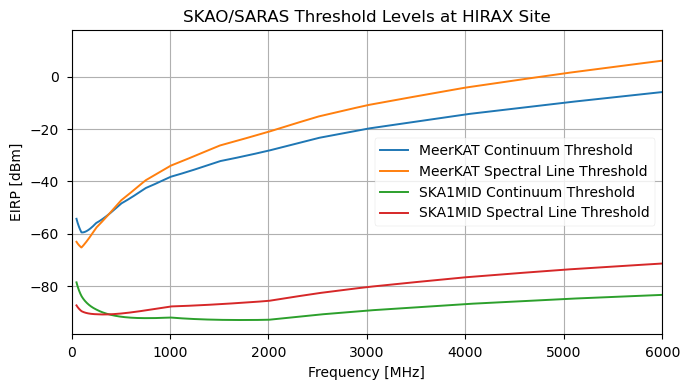

In [65]:
# This section is copied from above cells

#definition of SARAS according to SKA SA
#Frequency in MHz
lim_freqs = []
lim_freqs_low = np.linspace(50,2000,1000)
lim_freqs_high = np.linspace(2000.01,26000,20000)
lim_freqs.extend(lim_freqs_low)
lim_freqs.extend(lim_freqs_high)
lim_freqs = np.array(lim_freqs)
#print(freqs)
SARAS_continuum = []
SARAS_spectral = []
SARAS_continuum.extend(-17.2708 * np.log10(lim_freqs_low)-192.0714)
SARAS_continuum.extend(-0.065676 * np.log10(lim_freqs_high)-248.8661)
SARAS_spectral.extend(-17.2708 * np.log10(lim_freqs_low)-192.0714+15)
SARAS_spectral.extend(-0.065676 * np.log10(lim_freqs_high)-248.8661+15)

#Threshold levels in power (Effective Isotropic Radiated Power [EIRP] is assumed)
#Using RBW of 1% of observing frequncy for Continuum and 0.01% for Spectral Line Threshold
#dBm/Hz -> dBm
RBW_cont = 1/100*1e6*lim_freqs
RBW_spec = 0.001/100*1e6*lim_freqs
P_SARAS_continuum = SARAS_continuum + 10*np.log10(RBW_cont)
P_SARAS_spectral = SARAS_spectral + 10*np.log10(RBW_spec)

#Correct for the measurement RBW as stipulated in SKA-TEL-SKO-0001796-01
#Gets applied to only the Contimuun Threshold
#Assume a measurement RBW of 100 kHz for this example
MRBW = 120e3
BWCOMP = 10*np.log10(MRBW/(1/100*1e6*lim_freqs))
P_SARAS_continuum_adj = P_SARAS_continuum + BWCOMP

# End copied section


atten_freqs = [100,250,500,750,1000,1500,2000,2500,3000,4000,5000,6000]
meerkat_atten = [116.3187284,126.7817372,139.3422436,148.3331573,154.7774273,163.8111724,170.0180693,174.8434897,178.4210265,183.9201717,188.3852762,192.4739323]
# calculate the ska1mid attenuation values (because the ones in the google drive CSV are wrong)
meerkat_corrected = [-50.27213914,-42.72161555,-32.34334568,-24.61946597,-19.09393328,-11.34738115,-6.054459564,-0.5336836255,3.738510865,10.62697168,16.19856726,21.03890852]
meerkat_orig = np.array(meerkat_corrected) - np.array(meerkat_atten)
ska1mid_corrected = [-74.57549103,-75.78308364,-75.51924784,-74.30021253,-72.80836537,-71.95169876,-70.70055304,-68.04613432,-65.7719174,-61.88217428,-58.83402995,-56.5047593]
ska1mid_atten = np.array(ska1mid_corrected)-meerkat_orig

meerkat_atten = np.interp(lim_freqs, atten_freqs, meerkat_atten)
ska1mid_atten = np.interp(lim_freqs, atten_freqs, ska1mid_atten)

#print(FSPL[np.where(np.logical_and((freqs > 999.0), (freqs < 1001.0)))])
meerkat_SARAS_continuum_adj = P_SARAS_continuum_adj + meerkat_atten
meerkat_SARAS_spectral = P_SARAS_spectral + meerkat_atten
ska1mid_SARAS_continuum_adj = P_SARAS_continuum_adj + ska1mid_atten
ska1mid_SARAS_spectral = P_SARAS_spectral + ska1mid_atten

meerkat_combined = np.minimum(meerkat_SARAS_continuum_adj, meerkat_SARAS_spectral)
ska1mid_combined = np.minimum(ska1mid_SARAS_continuum_adj, ska1mid_SARAS_spectral)

#Plot the thresholds linearly
plt.rcdefaults()

plt.style.use("default")
plt.style.use("seaborn-paper")

params = {
    'axes.labelsize': 10,
    'font.size': 10,
    'axes.titlesize':12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'figure.figsize': [7, 4],
    'patch.facecolor': "white",
    }
plt.rcParams.update(params)

fig = plt.figure()

plt.title("SKAO/SARAS Threshold Levels at HIRAX Site")
plt.plot(lim_freqs,meerkat_SARAS_continuum_adj, label="MeerKAT Continuum Threshold")
plt.plot(lim_freqs,meerkat_SARAS_spectral, label="MeerKAT Spectral Line Threshold")
plt.plot(lim_freqs,ska1mid_SARAS_continuum_adj, label="SKA1MID Continuum Threshold")
plt.plot(lim_freqs,ska1mid_SARAS_spectral, label="SKA1MID Spectral Line Threshold")
# plt.plot(lim_freqs,meerkat_combined, label="Threshold imposed by MeerKAT")
# plt.plot(lim_freqs,ska1mid_combined, label="Threshold imposed by SKA1MID")
plt.xlabel("Frequency [MHz]")
plt.ylabel("EIRP [dBm]")
plt.xlim(0, 6000)
plt.grid(which="both")
plt.legend()
plt.tight_layout()
plt.savefig("./rfi_plots/limit_lines.png")
plt.show()

# GBO cage plots

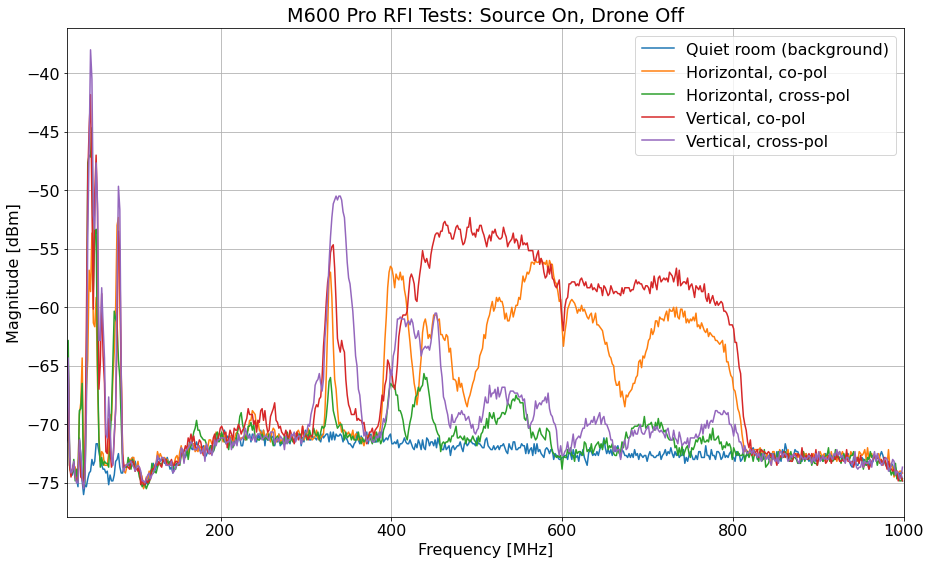

In [9]:
# noise source only

fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')
    
plt.plot(chamber['low']['freqs'], chamber['low']['bgnd'], label="Quiet room (background)")
plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['coh'], label="Horizontal, co-pol")
plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['xh'], label="Horizontal, cross-pol")
plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['cov'], label="Vertical, co-pol")
plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['xv'], label="Vertical, cross-pol")

plt.xlim(20,1000)
#plt.ylim(-100, -60)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Magnitude [dBm]")
plt.title("M600 Pro RFI Tests: Source On, Drone Off")
plt.legend()
plt.grid()

plt.savefig("./rfi_plots/source_on_drone_off.png")
plt.show()


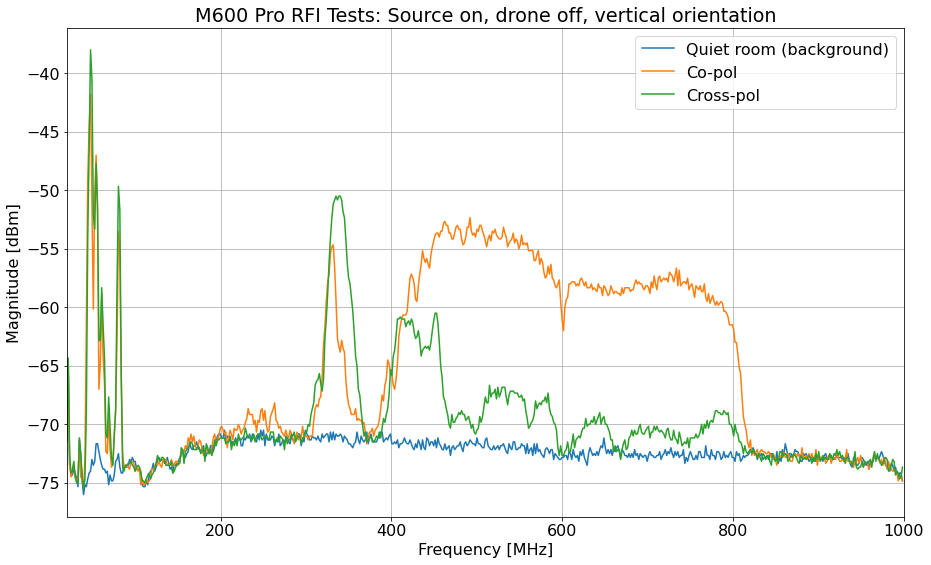

In [192]:
# noise source only

fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')
    
plt.plot(chamber['low']['freqs'], chamber['low']['bgnd'], label="Quiet room (background)")
# plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['coh'], label="Horizontal, co-pol")
# plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['xh'], label="Horizontal, cross-pol")
plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['cov'], label="Co-pol")
plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['xv'], label="Cross-pol")

plt.xlim(20,1000)
#plt.ylim(-100, -60)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Magnitude [dBm]")
plt.title("M600 Pro RFI Tests: Source on, drone off, vertical orientation")
plt.legend()
plt.grid()

plt.savefig("./rfi_plots/source_on_drone_off_vert.png")
plt.show()


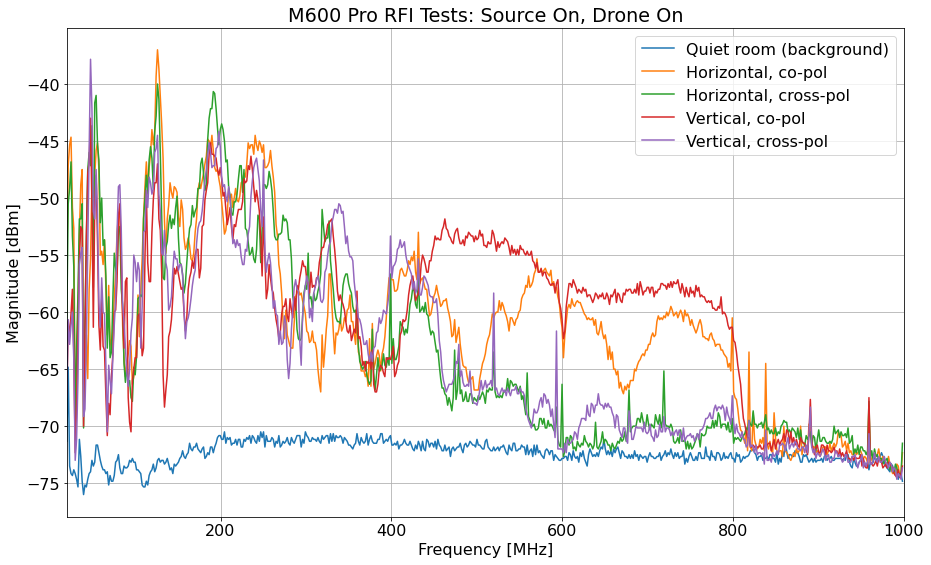

In [66]:
# noise source plus drone

fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')

plt.plot(chamber['low']['freqs'], chamber['low']['bgnd'], label="Quiet room (background)")
plt.plot(chamber['low']['freqs'], chamber['low']['nsdrone']['coh'], label="Horizontal, co-pol")
plt.plot(chamber['low']['freqs'], chamber['low']['nsdrone']['xh'], label="Horizontal, cross-pol")
plt.plot(chamber['low']['freqs'], chamber['low']['nsdrone']['cov'], label="Vertical, co-pol")
plt.plot(chamber['low']['freqs'], chamber['low']['nsdrone']['xv'], label="Vertical, cross-pol")


plt.xlim(20,1000)
#plt.ylim(-100, -60)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Magnitude [dBm]")
plt.title("M600 Pro RFI Tests: Source On, Drone On")
plt.legend()
plt.grid()

plt.savefig("./rfi_plots/source_on_drone_on.png")
plt.show()


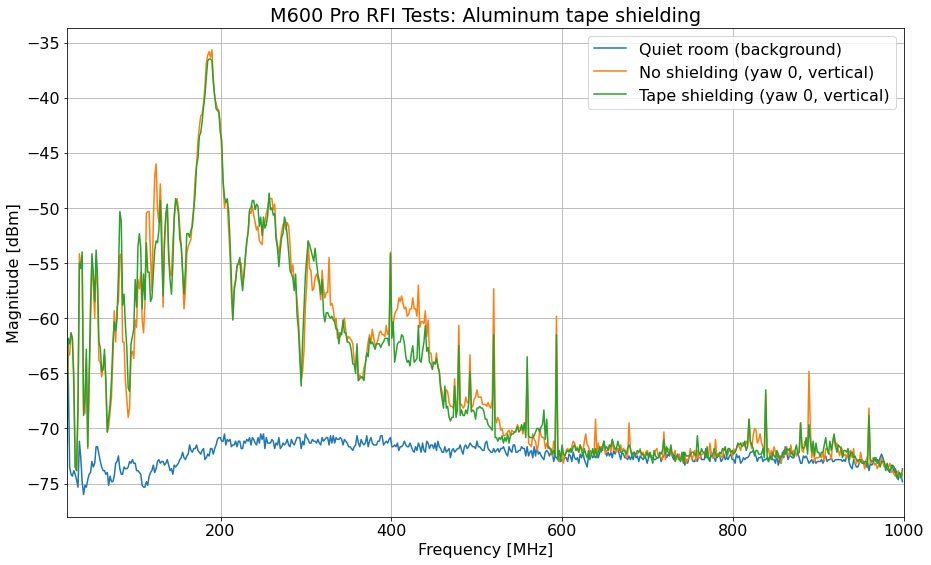

In [59]:
# shielding test

fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')
    
plt.plot(chamber['low']['freqs'], chamber['low']['bgnd'], label="Quiet room (background)")
plt.plot(chamber['low']['freqs'], chamber['low']['yaw']['0'], label="No shielding (yaw 0, vertical)")
plt.plot(chamber['low']['freqs'], chamber['low']['shield'], label="Tape shielding (yaw 0, vertical)")

plt.xlim(20,1000)
#plt.ylim(-100, -60)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Magnitude [dBm]")
plt.title("M600 Pro RFI Tests: Aluminum tape shielding")
plt.legend()
plt.grid()

plt.savefig("./rfi_plots/shielding.png")
plt.show()


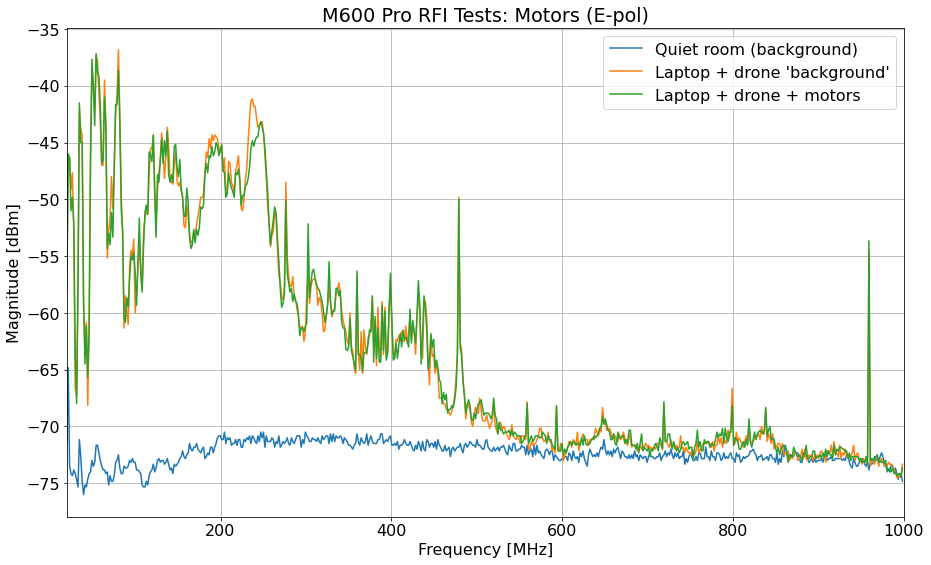

In [65]:
# motor test

fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')
    
plt.plot(chamber['low']['freqs'], chamber['low']['bgnd'], label="Quiet room (background)")

# plt.plot(chamber['low']['freqs'], chamber['low']['laptop']['hpol'], label="Laptop + drone 'background'")
# plt.plot(chamber['low']['freqs'], chamber['low']['motor']['hpol'], label="Laptop + drone + motors")

plt.plot(chamber['low']['freqs'], chamber['low']['laptop']['epol'], label="Laptop + drone 'background'")
plt.plot(chamber['low']['freqs'], chamber['low']['motor']['epol'], label="Laptop + drone + motors")

plt.xlim(20,1000)
#plt.ylim(-100, -60)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Magnitude [dBm]")
plt.title("M600 Pro RFI Tests: Motors (E-pol)")
plt.legend()
plt.grid()

plt.savefig("./rfi_plots/motors.png")
plt.show()


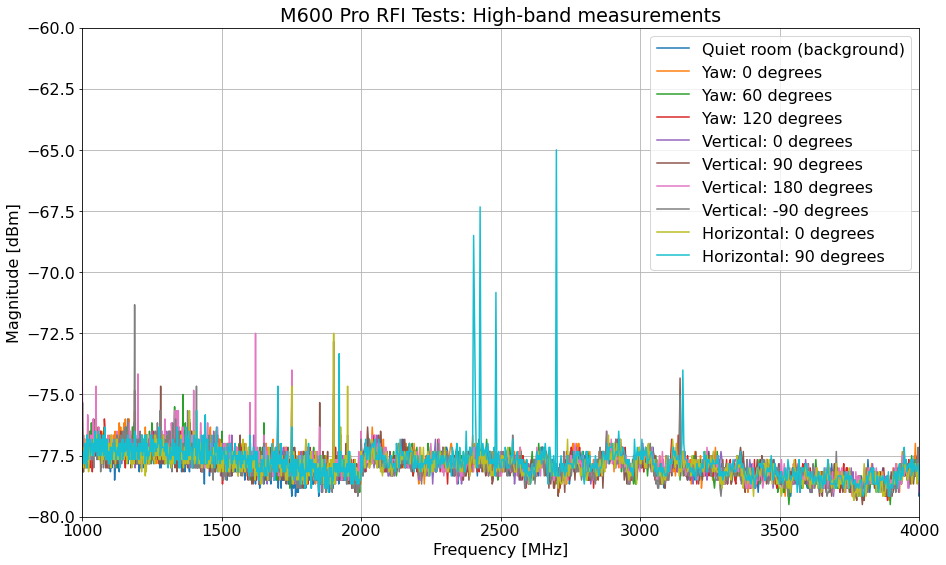

In [111]:
# shielding tests

fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')
    
plt.plot(chamber['high']['freqs'], chamber['high']['bgnd'], label="Quiet room (background)")
plt.plot(chamber['high']['freqs'], chamber['high']['yaw']['0'], label="Yaw: 0 degrees")
plt.plot(chamber['high']['freqs'], chamber['high']['yaw']['60'], label="Yaw: 60 degrees")
plt.plot(chamber['high']['freqs'], chamber['high']['yaw']['120'], label="Yaw: 120 degrees")
plt.plot(chamber['high']['freqs'], chamber['high']['vert']['0'], label="Vertical: 0 degrees")
plt.plot(chamber['high']['freqs'], chamber['high']['vert']['90'], label="Vertical: 90 degrees")
plt.plot(chamber['high']['freqs'], chamber['high']['vert']['180'], label="Vertical: 180 degrees")
plt.plot(chamber['high']['freqs'], chamber['high']['vert']['-90'], label="Vertical: -90 degrees")
plt.plot(chamber['high']['freqs'], chamber['high']['horiz']['0'], label="Horizontal: 0 degrees")
plt.plot(chamber['high']['freqs'], chamber['high']['horiz']['90'], label="Horizontal: 90 degrees")
# plt.plot(chamber['high']['freqs'], chamber['high']['laptop'], label="drone + laptop")
# plt.plot(chamber['high']['freqs'], chamber['high']['motor'], label="drone + laptop + motors")


plt.xlim(1000,4000)
plt.ylim(-80, -60)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Magnitude [dBm]")
plt.title("M600 Pro RFI Tests: High-band measurements")
plt.legend()
plt.grid()

plt.savefig("./rfi_plots/high_band.png")
plt.show()


# Unit conversions and comparisons

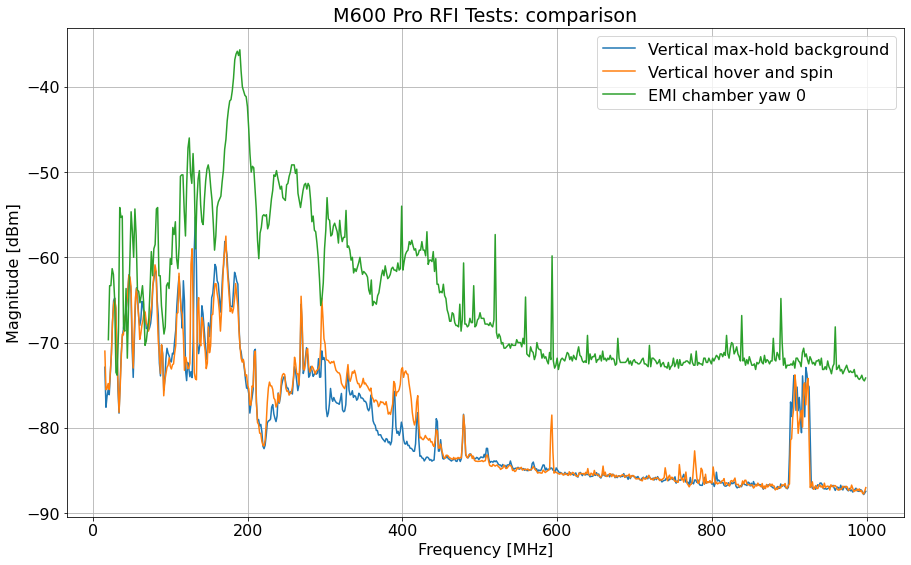

In [129]:
fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')
    
plt.plot(outdoor['yagi']['freqs'], outdoor['yagi']['bgnd']['v'], label="Vertical max-hold background")
plt.plot(outdoor['yagi']['freqs'], outdoor['yagi']['hover']['v'], label="Vertical hover and spin")
plt.plot(chamber['low']['freqs'], chamber['low']['yaw']['0'], label="EMI chamber yaw 0")

#plt.xlim(20,500)
#plt.ylim(-97, -80)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Magnitude [dBm]")
plt.title("M600 Pro RFI Tests: comparison")
plt.legend()
plt.grid()

plt.savefig("./rfi_plots/sloppy_comparison.png")
plt.show()

In [270]:
# test my corrections against carla's spreadsheet
idx = 200
f = chamber['low']['freqs']

print("freq: "+str(chamber['low']['freqs'][idx]))
print("measurement: "+str(chamber['low']['yaw']['0'][idx]))
print("my correction: "+str(chamber['low']['yaw']['0'][idx] + chamber_low_correction[idx]))
print("space loss: "+str(20.*np.log10(7)+20.*np.log10(chamber['low']['freqs'][idx])-27.55))
print("antenna gain: "+str(np.interp(f,lpda_freqs,lpda_mags)[idx]))
print("cable loss: "+str(-1*np.interp(f,allcable_freqs, allcable_mags)[idx]))

freq: 346.666666667
measurement: -61.16
my correction: -77.3580874930885
space loss: 40.150202491875845
antenna gain: 5.4006666666676
cable loss: 1.3314313158008884


In [254]:
idx = 100
f = oldout['wunfil']['freqs']
print(f[idx])
print(oldout['wunfil']['hovernear'][idx])
print(old_wunfil_near_correction[idx])
print(np.interp(f,zx60_43_freqs,zx60_43_mags)[idx])
print((20.*np.log10(3)+20.*np.log10(f)-27.55)[idx] - oscar18_gain - 1)

665.774647887324
-85.8213348388672
-31.703852112676056
22.703852112676056
27.45897016607003


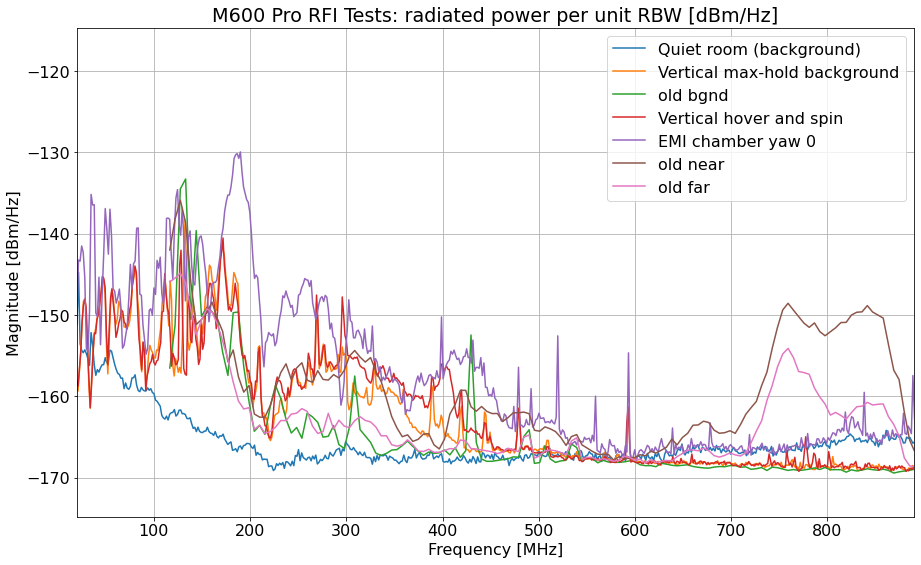

In [310]:
fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')
    
# plt.plot(outdoor['yagi']['freqs'], outdoor['yagi']['bgnd']['v']+outdoor_yagi_correction-(10.*np.log10(3000000)), label="Vertical max-hold background")
# plt.plot(outdoor['yagi']['freqs'], outdoor['yagi']['hover']['v']+outdoor_yagi_correction-(10.*np.log10(3000000)), label="Vertical hover and spin")
# plt.plot(chamber['low']['freqs'], chamber['low']['yaw']['0']+chamber_low_correction-(10.*np.log10(10000)), label="EMI chamber yaw 0")

# plt.plot(chamber['low']['freqs'], chamber['low']['bgnd']+chamber_low_correction, label="Quiet room (background)")
# plt.plot(outdoor['yagi']['freqs'], outdoor['yagi']['bgnd']['v']+outdoor_yagi_correction, label="Vertical max-hold background")
# #plt.plot(oldout["yagi"]["freqs"], oldout["yagi"]["bgnd"]+old_yagi_near_correction, label="old bgnd")
# plt.plot(outdoor['yagi']['freqs'], outdoor['yagi']['hover']['v']+outdoor_yagi_correction, label="Vertical hover and spin")
# plt.plot(chamber['low']['freqs'], chamber['low']['yaw']['0']+chamber_low_correction, label="EMI chamber yaw 0")
# #plt.plot(oldout["yagi"]["freqs"], oldout["yagi"]["hovernear"]['n']+old_yagi_near_correction, label="old near")
# #plt.plot(oldout["yagi"]["freqs"], oldout["yagi"]["hoverfar"]['n']+old_yagi_far_correction, label="old far")

plt.plot(chamber['low']['freqs'], chamber['low']['bgnd']+chamber_low_correction-(10.*np.log10(10000)), label="Quiet room (background)")
plt.plot(outdoor['yagi']['freqs'], outdoor['yagi']['bgnd']['v']+outdoor_yagi_correction-(10.*np.log10(3000000)), label="Vertical max-hold background")
plt.plot(oldout["yagi"]["freqs"], oldout["yagi"]["bgnd"]+old_yagi_near_correction-(10.*np.log10(3000000)), label="old bgnd")
plt.plot(outdoor['yagi']['freqs'], outdoor['yagi']['hover']['v']+outdoor_yagi_correction-(10.*np.log10(3000000)), label="Vertical hover and spin")
plt.plot(chamber['low']['freqs'], chamber['low']['yaw']['0']+chamber_low_correction-(10.*np.log10(10000)), label="EMI chamber yaw 0")
plt.plot(oldout["yagi"]["freqs"], oldout["yagi"]["hovernear"]['n']+old_yagi_near_correction-(10.*np.log10(3000000)), label="old near")
plt.plot(oldout["yagi"]["freqs"], oldout["yagi"]["hoverfar"]['n']+old_yagi_far_correction-(10.*np.log10(3000000)), label="old far")

# plt.plot(chamber['low']['freqs'], chamber['low']['bgnd'], label="Quiet room (background)")
# plt.plot(outdoor['yagi']['freqs'], outdoor['yagi']['bgnd']['v'], label="Vertical max-hold background")
# plt.plot(outdoor['yagi']['freqs'], outdoor['yagi']['hover']['v'], label="Vertical hover and spin")
# plt.plot(chamber['low']['freqs'], chamber['low']['yaw']['0'], label="EMI chamber yaw 0")
# plt.plot(oldout["wunfil"]["freqs"], oldout["wunfil"]["hovernear"], label="old near")
# plt.plot(oldout["wunfil"]["freqs"], oldout["wunfil"]["hoverfar"], label="old far")

plt.xlim(20,890)
#plt.ylim(-97, -80)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Magnitude [dBm/Hz]")
plt.title("M600 Pro RFI Tests: radiated power per unit RBW [dBm/Hz]")
plt.legend()
plt.grid()

plt.savefig("./rfi_plots/sloppy_comparison.png")
plt.show()

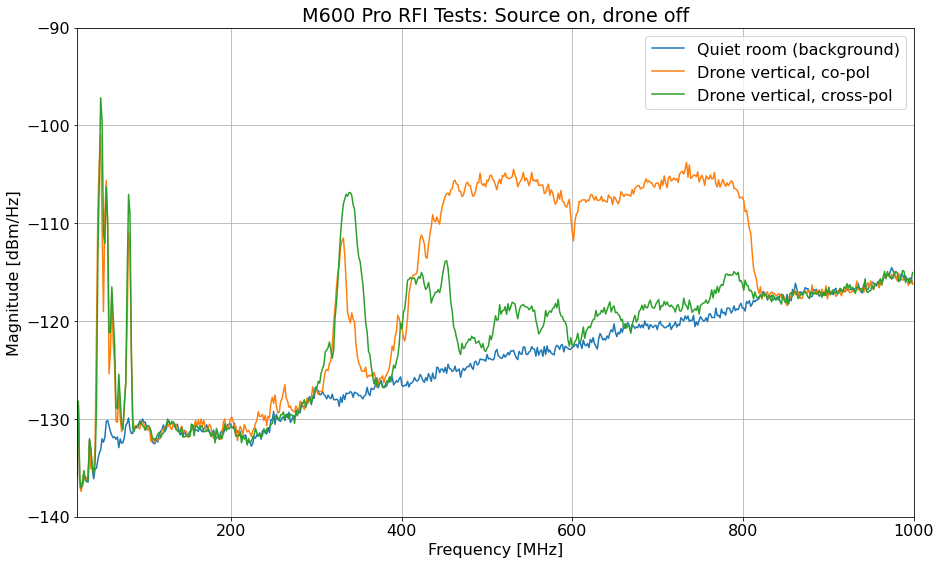

In [436]:
# noise source only

fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')
    
    
f = chamber['low']['freqs']
#chamber_low_correction = -1.*np.interp(f,allcable_freqs,allcable_mags) - np.interp(f,amp1306e_freqs,amp1306e_mags) - np.interp(f,lpda_freqs,lpda_mags)# + (20.*np.log10(7)+20.*np.log10(f)-27.55)

#-(10.*np.log10(10000))
plt.plot(chamber['low']['freqs'], chamber['low']['bgnd']+chamber_low_correction-(10.*np.log10(10000)), label="Quiet room (background)")
plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['cov']+chamber_low_correction-(10.*np.log10(10000)), label="Drone vertical, co-pol")
plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['xv']+chamber_low_correction-(10.*np.log10(10000)), label="Drone vertical, cross-pol")
# plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['coh']+chamber_low_correction-(10.*np.log10(10000)), label="Drone horizontal, co-pol")
# plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['xh']+chamber_low_correction-(10.*np.log10(10000)), label="Drone horizontal, cross-pol")

plt.xlim(20,1000)
plt.ylim(-140, -90)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Magnitude [dBm/Hz]")
plt.title("M600 Pro RFI Tests: Source on, drone off")
plt.legend()
plt.grid()

plt.savefig("./rfi_plots/source_on_drone_off_vert_cut_corrected.png")
plt.show()


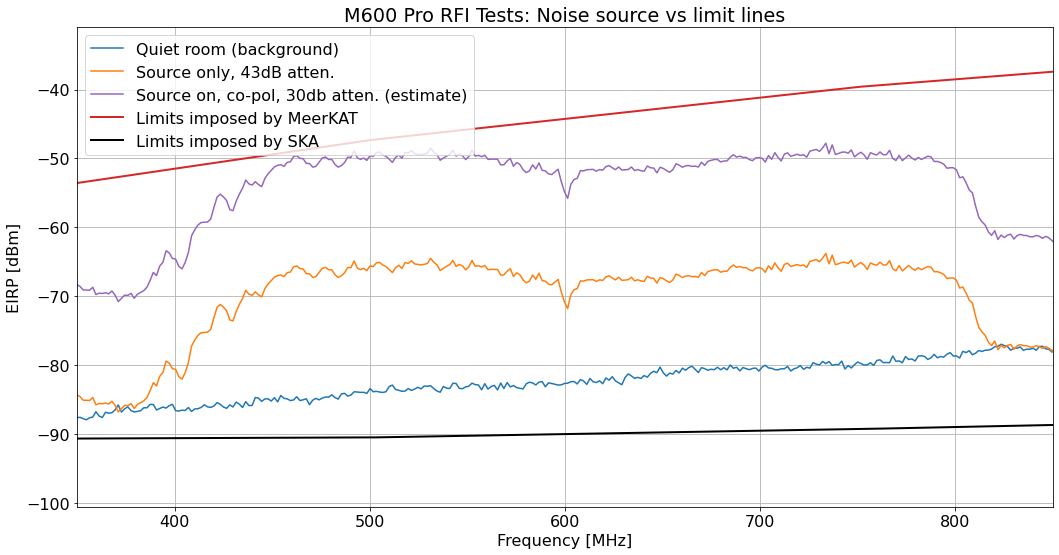

In [1309]:
# noise source only

f = chamber["low"]["freqs"]

####
# get ready to convert the EMI chamber data to dBuV/m at 10m
####

# total cable loss (assuming all cables are used in all cases)
cableab_interp = np.interp(cablech6_freqs, cableab_freqs, cableab_mags)
cableac_interp = np.interp(cablech6_freqs, cableac_freqs, cableac_mags)
allcable_freqs = cablech6_freqs
allcable_mags = cablech6_mags + cableab_interp + cableac_interp

# convert the antenna gain to an antenna factor
lpda_af = 20.*np.log10(lpda_freqs) - lpda_mags - 29.7707
lpda_af = np.interp(f, lpda_freqs, lpda_af)

# build a cable and amplifier gain correction
lo_cable_amp = -1.*np.interp(f, allcable_freqs, allcable_mags) - np.interp(f, amp1306e_freqs, amp1306e_mags)

# correction to convert measured dBm to EIRP
dbm_to_eirp = lo_cable_amp + lpda_af + 19.13

new_dbm_to_eirp = lo_cable_amp +20.*np.log10(f) + 20.*np.log10(7.) - np.interp(f, lpda_freqs, lpda_mags) - 27.56

# correction to convert measured dBm to dBuV/m at 3m
dbm_to_3m = lo_cable_amp + lpda_af + 114.36

# correction to convert measured dBm to dBuV/m at 10m
dbm_to_10m = lo_cable_amp + lpda_af + 103.9


fig = plt.figure(figsize=(15,8))
fig.patch.set_facecolor('white')
    
fcc_interp = np.interp(chamber['low']['freqs'], fccb_freqs, fccb_mags)

#plt.plot(chamber['low']['freqs'], fcc_interp, "--", color="tab:blue", label="FCC Part 15 Class B limit")
plt.plot(chamber['low']['freqs'], chamber['low']['bgnd']+new_dbm_to_eirp, label="Quiet room (background)")

plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['cov']+new_dbm_to_eirp, label="Source only, 43dB atten.")
#plt.plot(chamber['low']['freqs'], chamber['low']['nsdrone']['cov']+new_dbm_to_eirp, label="Source + drone, 43dB atten.")
#plt.plot(chamber['low']['freqs'], chamber["low"]["vert"]["0"]+dbm_to_eirp, label="Drone only")


plt.plot(chamber['low']['freqs'], chamber['low']['nsonly']['cov']+chamber_low_correction+16., label="Source on, co-pol, 30db atten. (estimate)", color="tab:purple")
plt.plot(f, np.interp(f, meerkat_freqs, meerkat_eirp_cont), label="Limits imposed by MeerKAT", color="tab:red", linewidth=2)
plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_eirp_cont), label="Limits imposed by SKA", color="black", linewidth=2)


plt.xlim(350,850)
#plt.ylim(-140, -90)
plt.xlabel("Frequency [MHz]")
plt.ylabel("EIRP [dBm]")
plt.title("M600 Pro RFI Tests: Noise source vs limit lines")
plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig("./rfi_plots/fcc_part15.png")
plt.show()


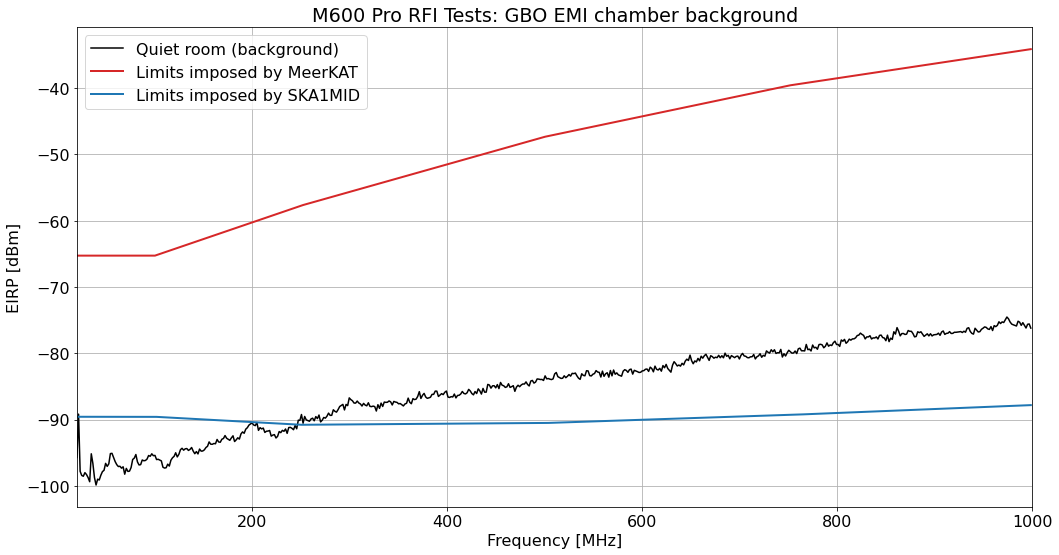

In [1050]:
# noise source only

f = chamber["low"]["freqs"]

####
# get ready to convert the EMI chamber data to dBuV/m at 10m
####

# total cable loss (assuming all cables are used in all cases)
cableab_interp = np.interp(cablech6_freqs, cableab_freqs, cableab_mags)
cableac_interp = np.interp(cablech6_freqs, cableac_freqs, cableac_mags)
allcable_freqs = cablech6_freqs
allcable_mags = cablech6_mags + cableab_interp + cableac_interp

# convert the antenna gain to an antenna factor
lpda_af = 20.*np.log10(lpda_freqs) - lpda_mags - 29.7707
lpda_af = np.interp(f, lpda_freqs, lpda_af)

# build a cable and amplifier gain correction
lo_cable_amp = -1.*np.interp(f, allcable_freqs, allcable_mags) - np.interp(f, amp1306e_freqs, amp1306e_mags)

# correction to convert measured dBm to EIRP
dbm_to_eirp = lo_cable_amp + lpda_af + 19.13

# correction to convert measured dBm to dBuV/m at 3m
dbm_to_3m = lo_cable_amp + lpda_af + 114.36

# correction to convert measured dBm to dBuV/m at 10m
dbm_to_10m = lo_cable_amp + lpda_af + 103.9


fig = plt.figure(figsize=(15,8))
fig.patch.set_facecolor('white')
    
#plt.plot(chamber['low']['freqs'], fcc_interp, "--", color="tab:blue", label="FCC Part 15 Class B limit")
plt.plot(chamber['low']['freqs'], chamber['low']['bgnd']+dbm_to_eirp, color="black", label="Quiet room (background)")

plt.plot(f, np.interp(f, meerkat_freqs, meerkat_eirp_cont), label="Limits imposed by MeerKAT", color="tab:red", linewidth=2)
plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_eirp_cont), label="Limits imposed by SKA1MID", color="tab:blue", linewidth=2)


plt.xlim(20,1000)
#plt.ylim(-140, -90)
plt.xlabel("Frequency [MHz]")
plt.ylabel("EIRP [dBm]")
plt.title("M600 Pro RFI Tests: GBO EMI chamber background")
plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig("./rfi_plots/background.png")
plt.show()


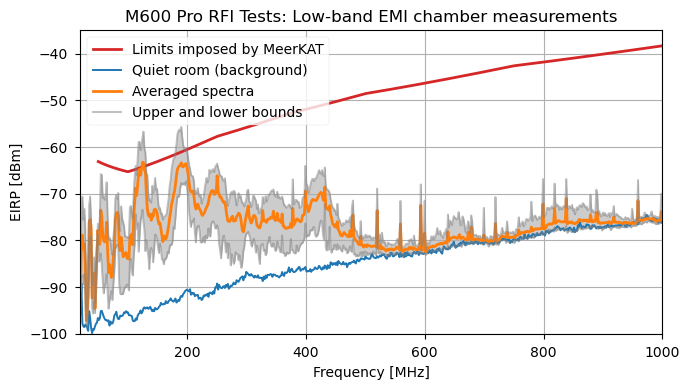

In [57]:
f = chamber["low"]["freqs"]

####
# get ready to convert the EMI chamber data to dBuV/m at 10m
####

# total cable loss (assuming all cables are used in all cases)
cableab_interp = np.interp(cablech6_freqs, cableab_freqs, cableab_mags)
cableac_interp = np.interp(cablech6_freqs, cableac_freqs, cableac_mags)
allcable_freqs = cablech6_freqs
allcable_mags = cablech6_mags + cableab_interp + cableac_interp

# convert the antenna gain to an antenna factor
lpda_af = 20.*np.log10(lpda_freqs) - lpda_mags - 29.7707
lpda_af = np.interp(f, lpda_freqs, lpda_af)

# build a cable and amplifier gain correction
lo_cable_amp = -1.*np.interp(f, allcable_freqs, allcable_mags) - np.interp(f, amp1306e_freqs, amp1306e_mags)

# make a big combined correction factor
chamber_corr = lo_cable_amp + lpda_af

# correction to convert measured dBm to EIRP
dbm_to_eirp = chamber_corr + 19.13

# correction to convert measured dBm to dBuV/m at 3m
dbm_to_3m = chamber_corr + 114.36

# correction to convert measured dBm to dBuV/m at 10m
dbm_to_10m = chamber_corr + 103.9


worst_yaw = np.maximum(chamber['low']['yaw']['0'], np.maximum(chamber['low']['yaw']['60'], chamber['low']['yaw']['120'])) # the worst-case yaw
worst_horiz = np.maximum(np.maximum(chamber['low']['horiz']['0'], chamber['low']['horiz']['90']), np.maximum(chamber['low']['horiz']['180'], chamber['low']['horiz']['270'])) # the worst-case horizontal
worst_vert = np.maximum(np.maximum(np.maximum(chamber['low']['vert']['0'], chamber['low']['vert']['15']), np.maximum(chamber['low']['vert']['30'], chamber['low']['vert']['45'])), 
                        np.maximum(np.maximum(np.maximum(chamber['low']['vert']['60'], chamber['low']['vert']['180']), np.maximum(chamber['low']['vert']['90'], chamber['low']['vert']['-15'])), 
                                   np.maximum(np.maximum(chamber['low']['vert']['-30'], chamber['low']['vert']['-45']), np.maximum(chamber['low']['vert']['-60'], chamber['low']['vert']['-90'])))) # the worst-case vertical (oof)
all_worst = np.maximum(np.maximum(worst_yaw, worst_horiz), worst_vert)

best_yaw  = np.minimum(chamber['low']['yaw']['0'], np.minimum(chamber['low']['yaw']['60'], chamber['low']['yaw']['120'])) # the worst-case yaw
best_horiz  = np.minimum(np.minimum(chamber['low']['horiz']['0'], chamber['low']['horiz']['90']), np.minimum(chamber['low']['horiz']['180'], chamber['low']['horiz']['270'])) # the worst-case horizontal
best_vert  = np.minimum(np.minimum(np.minimum(chamber['low']['vert']['0'], chamber['low']['vert']['15']), np.minimum(chamber['low']['vert']['30'], chamber['low']['vert']['45'])), 
                        np.minimum(np.minimum(np.minimum(chamber['low']['vert']['60'], chamber['low']['vert']['180']), np.minimum(chamber['low']['vert']['90'], chamber['low']['vert']['-15'])), 
                                   np.minimum(np.minimum(chamber['low']['vert']['-30'], chamber['low']['vert']['-45']), np.minimum(chamber['low']['vert']['-60'], chamber['low']['vert']['-90'])))) # the worst-case vertical (oof)
all_best = np.minimum(np.minimum(best_yaw, best_horiz), best_vert)

averaged_spectra = avg_spectra([chamber['low']['yaw']['0'], chamber['low']['yaw']['60'], chamber['low']['yaw']['120'], chamber['low']['horiz']['0'], 
                                chamber['low']['horiz']['90'], chamber['low']['horiz']['180'], chamber['low']['horiz']['270'], chamber['low']['vert']['0'], 
                                chamber['low']['vert']['15'], chamber['low']['vert']['30'], chamber['low']['vert']['45'], chamber['low']['vert']['60'], 
                                chamber['low']['vert']['180'], chamber['low']['vert']['90'], chamber['low']['vert']['-15'], chamber['low']['vert']['-30'], 
                                chamber['low']['vert']['-45'], chamber['low']['vert']['-60'], chamber['low']['vert']['-90']])

plt.rcdefaults()

plt.style.use("default")
plt.style.use("seaborn-paper")

params = {
    'axes.labelsize': 10,
    'font.size': 10,
    'axes.titlesize':12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'figure.figsize': [7, 4],
    'patch.facecolor': "white",
    }
plt.rcParams.update(params)

fig = plt.figure()

#plt.plot(f, np.interp(f, meerkat_freqs, meerkat_eirp_cont), label="Limits imposed by MeerKAT", color="tab:red", linewidth=2)
plt.plot(lim_freqs, meerkat_combined, label="Limits imposed by MeerKAT", color="tab:red", linewidth=2)
#plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_eirp_cont), label="Limits imposed by SKA1MID", color="tab:green", linewidth=3)
#plt.plot(f, np.interp(f, meerkat_freqs, meerkat_eirp_spec), color="tab:red", linewidth=2)
#plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_eirp_spec), color="tab:green", linewidth=2)

plt.plot(chamber['low']['freqs'], chamber['low']['bgnd']+dbm_to_eirp, label="Quiet room (background)")
plt.plot(chamber['low']['freqs'], averaged_spectra+dbm_to_eirp, label="Averaged spectra", linewidth=2)
plt.plot(chamber['low']['freqs'], all_worst+dbm_to_eirp, color='grey', alpha=0.5, label="Upper and lower bounds")
plt.plot(chamber['low']['freqs'], all_best+dbm_to_eirp, color='grey', alpha=0.5)

plt.fill_between(chamber['low']['freqs'], all_worst+dbm_to_eirp, all_best+dbm_to_eirp, color="grey", alpha=0.4)

plt.xlim(20,1000)
plt.ylim(-100, -35)
plt.xlabel("Frequency [MHz]")
plt.ylabel("EIRP [dBm]")
plt.title("M600 Pro RFI Tests: Low-band EMI chamber measurements")
plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig("./rfi_plots/low_min_max.png")
plt.show()

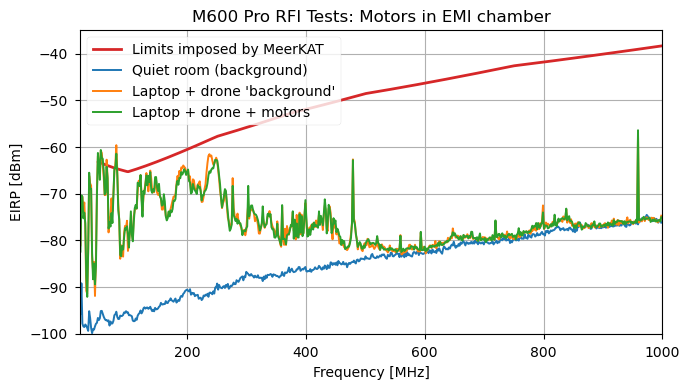

In [58]:
f = chamber["low"]["freqs"]

####
# get ready to convert the EMI chamber data to dBuV/m at 10m
####

# total cable loss (assuming all cables are used in all cases)
cableab_interp = np.interp(cablech6_freqs, cableab_freqs, cableab_mags)
cableac_interp = np.interp(cablech6_freqs, cableac_freqs, cableac_mags)
allcable_freqs = cablech6_freqs
allcable_mags = cablech6_mags + cableab_interp + cableac_interp

# convert the antenna gain to an antenna factor
lpda_af = 20.*np.log10(lpda_freqs) - lpda_mags - 29.7707
lpda_af = np.interp(f, lpda_freqs, lpda_af)

# build a cable and amplifier gain correction
lo_cable_amp = -1.*np.interp(f, allcable_freqs, allcable_mags) - np.interp(f, amp1306e_freqs, amp1306e_mags)

# make a big combined correction factor
chamber_corr = lo_cable_amp + lpda_af

# correction to convert measured dBm to EIRP
dbm_to_eirp = chamber_corr + 19.13

# correction to convert measured dBm to dBuV/m at 3m
dbm_to_3m = chamber_corr + 114.36

# correction to convert measured dBm to dBuV/m at 10m
dbm_to_10m = chamber_corr + 103.9

plt.rcdefaults()

plt.style.use("default")
plt.style.use("seaborn-paper")

params = {
    'axes.labelsize': 10,
    'font.size': 10,    
    'axes.titlesize':12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'figure.figsize': [7, 4],
    'patch.facecolor': "white",
    }
plt.rcParams.update(params)

fig = plt.figure()


plt.plot(lim_freqs, meerkat_combined, label="Limits imposed by MeerKAT", color="tab:red", linewidth=2)

plt.plot(chamber['low']['freqs'], chamber['low']['bgnd']+dbm_to_eirp, label="Quiet room (background)")

plt.plot(chamber['low']['freqs'], chamber['low']['laptop']['epol']+dbm_to_eirp, label="Laptop + drone 'background'")
plt.plot(chamber['low']['freqs'], chamber['low']['motor']['epol']+dbm_to_eirp, label="Laptop + drone + motors")

plt.xlim(20,1000)
plt.ylim(-100, -35)
plt.xlabel("Frequency [MHz]")
plt.ylabel("EIRP [dBm]")
plt.title("M600 Pro RFI Tests: Motors in EMI chamber")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("./rfi_plots/motor_chamber.png")
plt.show()


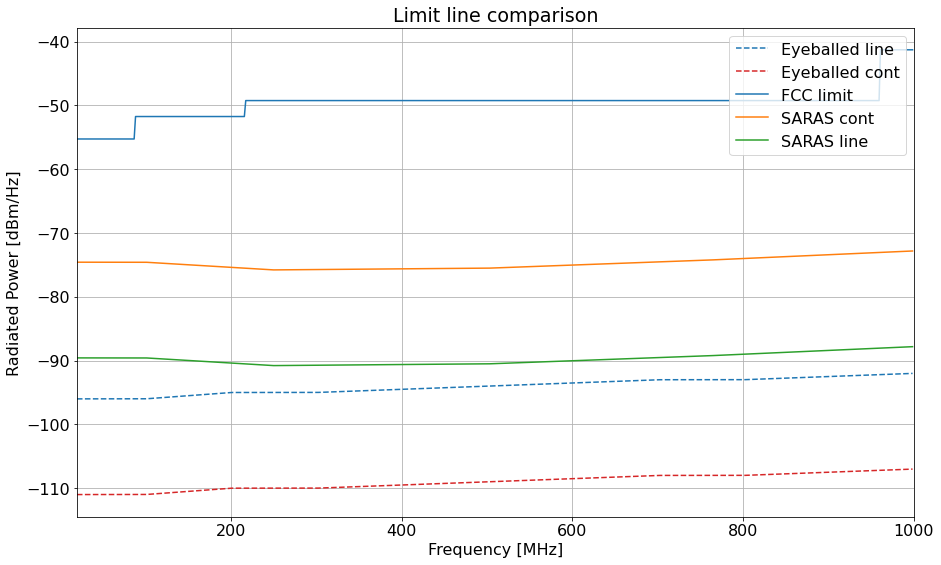

In [704]:
# plot some precompliance tests from the lab faraday cage


fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')

f = chamber["low"]["freqs"]

ska_line_interp = np.interp(f, ska_freqs, ska_line_mags)
ska_cont_interp = np.interp(f, ska_freqs, ska_cont_mags)

plt.plot(f, np.interp(f, ska_freqs, ska_line_mags), "--", color="tab:blue", label="Eyeballed line")
plt.plot(f, np.interp(f, ska_freqs, ska_cont_mags), "--", color="tab:red", label="Eyeballed cont")
plt.plot(f, np.interp(f, fccb_freqs, fccb_mags), label="FCC limit")
plt.plot(f, np.interp(f, hirax_saras_cont_freqs, hirax_saras_cont_mags), label="SARAS cont")
plt.plot(f, np.interp(f, hirax_saras_line_freqs, hirax_saras_line_mags), label="SARAS line")


plt.xlim(20,1000)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Radiated Power [dBm/Hz]")
plt.title("Limit line comparison")
plt.legend()
plt.grid()

plt.show()


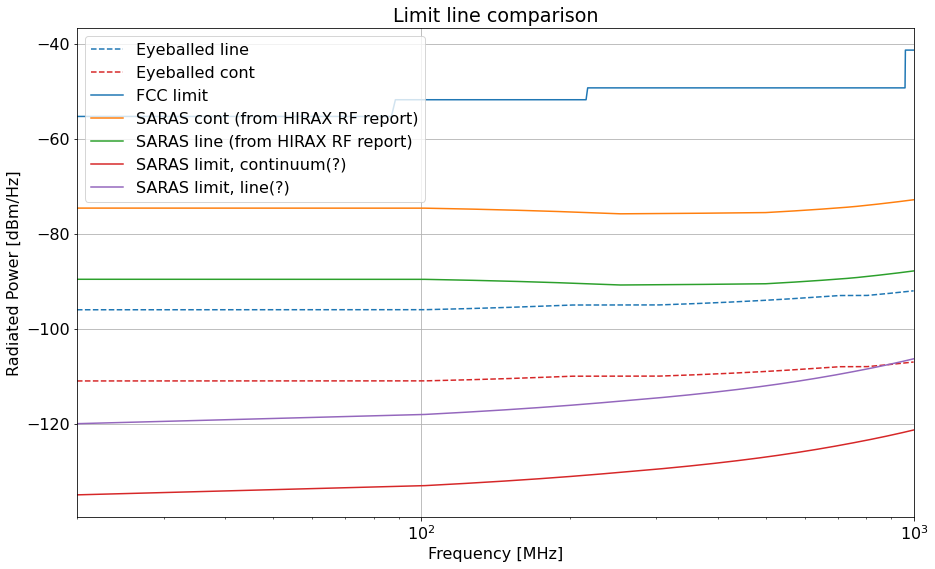

In [812]:
# calculating the SARAS protection levels myself
fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')

# from SSA-0008A-038 Rev 01 Applying Telescope Protection Levels:
# Below 2GHz, SARAS[dBm/Hz] = -17.2708*log10(f) - 192.0714
# Above 2GHz, SARAS[dBm/Hz] = -0.065676*log10(f) - 248.8661
# For f in MHz
# Continuum limit assumes reciever bandwidth of 1% of center frequency
# Spetral line limit assumes receiver bandwidth of 0.001% of center frequency

f = chamber["low"]["freqs"]

# calculate the protection levels from 0 to 1GHz
saras_limits = np.log10(f)*-17.2708 - 192.0714 # in dBm/Hz

# convert these limits from dBm/Hz (PSD) to dBm/m^2/Hz (SPFD)
saras_spfd = saras_limits + 20.*np.log10(f*1000000) - 158.5

# correct them based on the calculated path loss/terrain attenuation
meerkat_atten = [116.3187284,126.7817372,139.3422436,148.3331573,154.7774273,163.8111724,170.0180693,174.8434897,178.4210265,183.9201717,188.3852762,192.4739323]
# calculate the ska1mid attenuation values (because the ones in the google drive CSV are wrong)
meerkat_corrected = [-50.27213914,-42.72161555,-32.34334568,-24.61946597,-19.09393328,-11.34738115,-6.054459564,-0.5336836255,3.738510865,10.62697168,16.19856726,21.03890852]
meerkat_orig = np.array(meerkat_corrected) - np.array(meerkat_atten)
ska1mid_corrected = [-74.57549103,-75.78308364,-75.51924784,-74.30021253,-72.80836537,-71.95169876,-70.70055304,-68.04613432,-65.7719174,-61.88217428,-58.83402995,-56.5047593]
ska1mid_atten = np.array(ska1mid_corrected)-meerkat_orig
saras_atten = np.interp(f, hirax_saras_cont_freqs, ska1mid_atten)

# where do the continuum and line RBW corrections start to exceed 1?

ska_line_interp = np.interp(f, ska_freqs, ska_line_mags)
ska_cont_interp = np.interp(f, ska_freqs, ska_cont_mags)

plt.plot(f, np.interp(f, ska_freqs, ska_line_mags), "--", color="tab:blue", label="Eyeballed line")
plt.plot(f, np.interp(f, ska_freqs, ska_cont_mags), "--", color="tab:red", label="Eyeballed cont")
plt.plot(f, np.interp(f, fccb_freqs, fccb_mags), label="FCC limit")
plt.plot(f, np.interp(f, hirax_saras_cont_freqs, hirax_saras_cont_mags), label="SARAS cont (from HIRAX RF report)")
plt.plot(f, np.interp(f, hirax_saras_line_freqs, hirax_saras_line_mags), label="SARAS line (from HIRAX RF report)")
#plt.plot(f, saras_limits, label="SARAS limit, no BW factor")
plt.plot(f, saras_spfd + saras_atten, label="SARAS limit, continuum(?)")
plt.plot(f, saras_spfd + saras_atten + 15., label="SARAS limit, line(?)")


plt.xlim(20,1000)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Radiated Power [dBm/Hz]")
plt.title("Limit line comparison")
plt.semilogx()
plt.legend()
plt.grid()

plt.show()


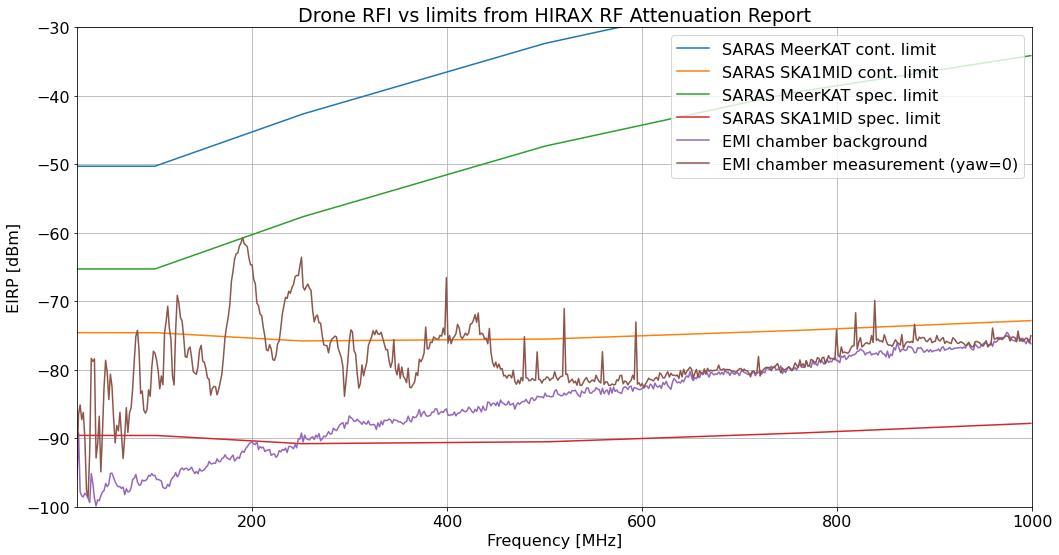

In [878]:
f = chamber["low"]["freqs"]

####
# get ready to convert the EMI chamber data to dBuV/m at 10m
####

# total cable loss (assuming all cables are used in all cases)
cableab_interp = np.interp(cablech6_freqs, cableab_freqs, cableab_mags)
cableac_interp = np.interp(cablech6_freqs, cableac_freqs, cableac_mags)
allcable_freqs = cablech6_freqs
allcable_mags = cablech6_mags + cableab_interp + cableac_interp

# convert the antenna gain to an antenna factor
lpda_af = 20.*np.log10(lpda_freqs) - lpda_mags - 29.7707
lpda_af = np.interp(f, lpda_freqs, lpda_af)

# build a cable and amplifier gain correction
lo_cable_amp = -1.*np.interp(f, allcable_freqs, allcable_mags) - np.interp(f, amp1306e_freqs, amp1306e_mags)

# correction to convert measured dBm to EIRP
dbm_to_eirp = lo_cable_amp + lpda_af + 19.13

# correction to convert measured dBm to dBuV/m at 3m
dbm_to_3m = lo_cable_amp + lpda_af + 114.36

# correction to convert measured dBm to dBuV/m at 10m
dbm_to_10m = lo_cable_amp + lpda_af + 103.9

####
# Bandwidth compensation
####

# from Applying Telescope Protection Levels, equation 14
# PSD_comp = PSD_thresh * (BW_thresh/BW_meas)
# where BW_thresh = 1% * f for continuum and BW_thresh = 0.001% * f for spectral line
bw_comp_cont = (0.01*f)/(0.01) # 1% of frequency divided by (10kHz in MHz)
bw_comp_spec = (0.00001*f)/(0.01) # 0.001% of frequency divided by (10kHz in MHz)

# these compensation factors are (I think) in linear units, so...
bw_comp_cont = 10.*np.log10(bw_comp_cont)
bw_comp_spec = 10.*np.log10(bw_comp_spec)

####
# plot!
####

# fig = plt.figure(figsize=(15,8))
# fig.patch.set_facecolor('white')

# plt.plot(f, np.interp(f, meerkat_freqs, meerkat_10m_cont), label="SARAS MeerKAT cont. limit")
# plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_10m_cont), label="SARAS SKA1MID cont. limit")
# plt.plot(f, np.interp(f, meerkat_freqs, meerkat_10m_spec), label="SARAS MeerKAT spec. limit")
# plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_10m_spec), label="SARAS SKA1MID spec. limit")
# plt.plot(f, chamber["low"]["bgnd"]+dbm_to_10m, label="EMI chamber background")
# plt.plot(f, chamber["low"]["long"][0]+dbm_to_10m, label="EMI chamber measurement (yaw=0)")


# plt.xlim(20,1000)
# plt.xlabel("Frequency [MHz]")
# plt.ylabel("Electric Field Strength at 10 meters [dBuV/m]")
# plt.title("Limit line comparison")
# #plt.semilogx()
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()


fig = plt.figure(figsize=(15,8))
fig.patch.set_facecolor('white')

plt.plot(f, np.interp(f, meerkat_freqs, meerkat_eirp_cont), label="SARAS MeerKAT cont. limit")
plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_eirp_cont), label="SARAS SKA1MID cont. limit")
plt.plot(f, np.interp(f, meerkat_freqs, meerkat_eirp_spec), label="SARAS MeerKAT spec. limit")
plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_eirp_spec), label="SARAS SKA1MID spec. limit")
plt.plot(f, chamber["low"]["bgnd"]+dbm_to_eirp, label="EMI chamber background")
plt.plot(f, chamber["low"]["long"][0]+dbm_to_eirp, label="EMI chamber measurement (yaw=0)")


plt.xlim(20,1000)
plt.xlabel("Frequency [MHz]")
plt.ylabel("EIRP [dBm]")
plt.title("Drone RFI vs limits from HIRAX RF Attenuation Report")
plt.ylim(-100, -30)
#plt.semilogx()
plt.legend(loc="upper right")
plt.grid()
plt.tight_layout()
plt.savefig("./rfi_plots/hirax_eirp_lines.png")
plt.show()

Remote low: 5.4566666666666634
Remote high: 0.0933333333333195
Drone: 2.25
RTK air: 9.656666666666666
RTK ground: 9.159999999999997
21.63076030454666
-4.846817720419681
18.411211827376665
45.64769950356666
45.14919099266999
-44.5540788896


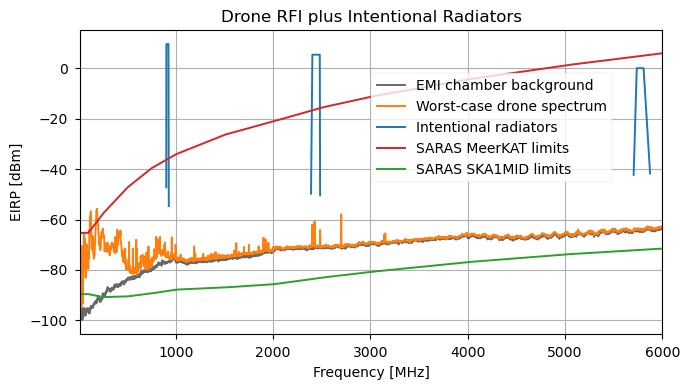

In [74]:
f_lo = chamber["low"]["freqs"]
f_hi = chamber["high"]["freqs"]
f = np.concatenate((f_lo, f_hi))

worst_yaw = np.maximum(chamber['low']['yaw']['0'], np.maximum(chamber['low']['yaw']['60'], chamber['low']['yaw']['120'])) # the worst-case yaw
worst_horiz = np.maximum(np.maximum(chamber['low']['horiz']['0'], chamber['low']['horiz']['90']), np.maximum(chamber['low']['horiz']['180'], chamber['low']['horiz']['270'])) # the worst-case horizontal
worst_vert = np.maximum(np.maximum(np.maximum(chamber['low']['vert']['0'], chamber['low']['vert']['15']), np.maximum(chamber['low']['vert']['30'], chamber['low']['vert']['45'])), 
                        np.maximum(np.maximum(np.maximum(chamber['low']['vert']['60'], chamber['low']['vert']['180']), np.maximum(chamber['low']['vert']['90'], chamber['low']['vert']['-15'])), 
                                   np.maximum(np.maximum(chamber['low']['vert']['-30'], chamber['low']['vert']['-45']), np.maximum(chamber['low']['vert']['-60'], chamber['low']['vert']['-90'])))) # the worst-case vertical (oof)
worst_low = np.maximum(np.maximum(worst_yaw, worst_horiz), worst_vert)


worst_yaw = np.maximum(chamber['high']['yaw']['0'], np.maximum(chamber['high']['yaw']['60'], chamber['high']['yaw']['120'])) # the worst-case yaw
worst_horiz = np.maximum(chamber['high']['horiz']['0'], chamber['high']['horiz']['90']) # the worst-case horizontal
worst_vert = np.maximum(np.maximum(chamber['high']['vert']['0'], chamber['high']['vert']['180']), np.maximum(chamber['high']['vert']['90'], chamber['high']['vert']['-90']))
worst_high = np.maximum(np.maximum(worst_yaw, worst_horiz), worst_vert)


####
# get ready to convert the EMI chamber data to dBuV/m at 10m
####

# total cable loss (assuming all cables are used in all cases)
cableab_interp = np.interp(cablech6_freqs, cableab_freqs, cableab_mags)
cableac_interp = np.interp(cablech6_freqs, cableac_freqs, cableac_mags)
allcable_freqs = cablech6_freqs
allcable_mags = cablech6_mags + cableab_interp + cableac_interp

# convert the antenna gain to an antenna factor
lpda_af = 20.*np.log10(lpda_freqs) - lpda_mags - 29.7707
lpda_af = np.interp(f_lo, lpda_freqs, lpda_af)

horn_af = 20.*np.log10(horn_freqs) - horn_mags - 29.7707
horn_af = np.interp(f_hi, horn_freqs, horn_af)

# build a cable and amplifier gain correction
lo_cable_amp = -1.*np.interp(f_lo, allcable_freqs, allcable_mags) - np.interp(f_lo, amp1306e_freqs, amp1306e_mags)
hi_cable_amp = -1.*np.interp(f_hi, allcable_freqs, allcable_mags) - np.interp(f_hi, ampamf6d_freqs, ampamf6d_mags)

# make a big combined correction factor
chamber_corr = np.concatenate((lo_cable_amp, hi_cable_amp)) + np.concatenate((lpda_af, horn_af))

# correction to convert measured dBm to EIRP
dbm_to_eirp = chamber_corr + 19.13

# correction to convert measured dBm to dBuV/m at 3m
dbm_to_3m = chamber_corr + 114.36

# correction to convert measured dBm to dBuV/m at 10m
dbm_to_10m = chamber_corr + 103.9

####
# Bandwidth compensation
####

# from Applying Telescope Protection Levels, equation 14
# PSD_comp = PSD_thresh * (BW_thresh/BW_meas)
# where BW_thresh = 1% * f for continuum and BW_thresh = 0.001% * f for spectral line
bw_comp_cont = (0.01*f)/(0.01) # 1% of frequency divided by (10kHz in MHz)
bw_comp_spec = (0.00001*f)/(0.01) # 0.001% of frequency divided by (10kHz in MHz)

# these compensation factors are (I think) in linear units, so...
bw_comp_cont = 10.*np.log10(bw_comp_cont)
bw_comp_spec = 10.*np.log10(bw_comp_spec)

####
# FCC data on intentional emitters
####

# all data was using the average detector (as opposed to peak or quasi-peak)
# all data is in units of dBuV/m at 3m, then converted to EIRP by subtracting 95.23
# all data chooses the worst/most common polarization. All sets of measurements are at the same polarization.

# drone
fcc_drone_freqs = [2390, 2406.5, 2446.5, 2476.5, 2483.5]
fcc_drone_mags = np.array([43.66, np.mean([97.07, 97.23, 98.14]),np.mean([97.07, 97.23, 98.14]),np.mean([97.07, 97.23, 98.14]), 53.36]) - 95.23

# remote
remote_lo_freqs = [2390, 2404, 2442, 2480, 2483.5]
remote_lo_mags = np.array([45.52, np.mean([99.74, 100.74, 101.58]),np.mean([99.74, 100.74, 101.58]),np.mean([99.74, 100.74, 101.58]), 50]) - 95.23
remote_hi_freqs = [5706, 5738, 5773, 5808, 5875]
remote_hi_mags = np.array([52.98, np.mean([96.49, 95.59, 93.89]),np.mean([96.49, 95.59, 93.89]),np.mean([96.49, 95.59, 93.89]), 50]) - 95.23

# RTK air unit
# quasipeak measurements have had 10dBs subtracted from them
# this reflects the fact that CISPR 22 places its average limits lines 10dBs down from its QP lines
rtk_air_freqs = [902, 903, 914.5, 925, 928]
rtk_air_mags = np.array([50, np.mean([107.55, 108.19, 107.92]),np.mean([107.55, 108.19, 107.92]),np.mean([107.55, 108.19, 107.92]), 50])-95.23 -3

# RTK ground unit
# same QP -> average corrections
rtk_ground_freqs = [902, 903, 914.25, 925.5, 928]
rtk_ground_mags = np.array([50, 107.25, 107.49, 107.43, 50])-95.23-3


print("Remote low: "+str(np.mean(remote_lo_mags[1:-1])))
print("Remote high: "+str(np.mean(remote_hi_mags[1:-1])))
print("Drone: "+str(np.mean(fcc_drone_mags[1:-1])))
print("RTK air: "+str(np.mean(rtk_air_mags[1:-1])))
print("RTK ground: "+str(np.mean(rtk_ground_mags[1:-1])))

print(np.mean(remote_lo_mags[1:-1] - np.interp(remote_lo_freqs[1:-1], meerkat_freqs, meerkat_eirp_cont)))
print(np.mean(remote_hi_mags[1:-1] - np.interp(remote_hi_freqs[1:-1], meerkat_freqs, meerkat_eirp_cont)))
print(np.mean(fcc_drone_mags[1:-1] - np.interp(fcc_drone_freqs[1:-1], meerkat_freqs, meerkat_eirp_cont)))
print(np.mean(rtk_air_mags[1:-1] - np.interp(rtk_air_freqs[1:-1], meerkat_freqs, meerkat_eirp_cont)))
print(np.mean(rtk_ground_mags[1:-1] - np.interp(rtk_ground_freqs[1:-1], meerkat_freqs, meerkat_eirp_cont)))
print(np.mean(np.interp([400, 500, 600, 700, 800], meerkat_freqs, meerkat_eirp_cont)))

# print(np.mean(np.interp(remote_lo_freqs[1:-1], meerkat_freqs, meerkat_eirp_cont)))
# print(np.mean(np.interp(remote_hi_freqs[1:-1], meerkat_freqs, meerkat_eirp_cont)))
# print(np.mean(np.interp(fcc_drone_freqs[1:-1], meerkat_freqs, meerkat_eirp_cont)))
# print(np.mean(np.interp(rtk_air_freqs[1:-1], meerkat_freqs, meerkat_eirp_cont)))
# print(np.mean(np.interp(rtk_ground_freqs[1:-1], meerkat_freqs, meerkat_eirp_cont)))

####
# plot!
####

plt.rcdefaults()

plt.style.use("default")
plt.style.use("seaborn-paper")

params = {
    'axes.labelsize': 10,
    'font.size': 10,
    'axes.titlesize':12,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'figure.figsize': [7, 4],
    'patch.facecolor': "white",
    }
plt.rcParams.update(params)

fig = plt.figure()

plt.plot(f, np.concatenate((chamber["low"]["bgnd"], chamber["high"]["bgnd"]))+dbm_to_eirp, label="EMI chamber background", color="dimgrey")
plt.plot(f, np.concatenate((worst_low, worst_high))+dbm_to_eirp, label="Worst-case drone spectrum", color="tab:orange")
plt.plot(rtk_air_freqs, rtk_air_mags, color="tab:blue", label="Intentional radiators")
plt.plot(remote_lo_freqs, remote_lo_mags, color="tab:blue")
plt.plot(remote_hi_freqs, remote_hi_mags, color="tab:blue")

plt.plot(f, np.interp(f, meerkat_freqs, meerkat_eirp_cont), label="SARAS MeerKAT limits", color="tab:red")
plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_eirp_cont), label="SARAS SKA1MID limits", color="tab:green")

plt.xlim(20,6000)
plt.xlabel("Frequency [MHz]")
plt.ylabel("EIRP [dBm]")
plt.title("Drone RFI plus Intentional Radiators")
#plt.ylim(-100, -30)
#plt.semilogx()
plt.legend(loc=(0.5,0.5))
plt.grid()
plt.tight_layout()
plt.savefig("./rfi_plots/hirax_plus_intentional.png")
plt.show()

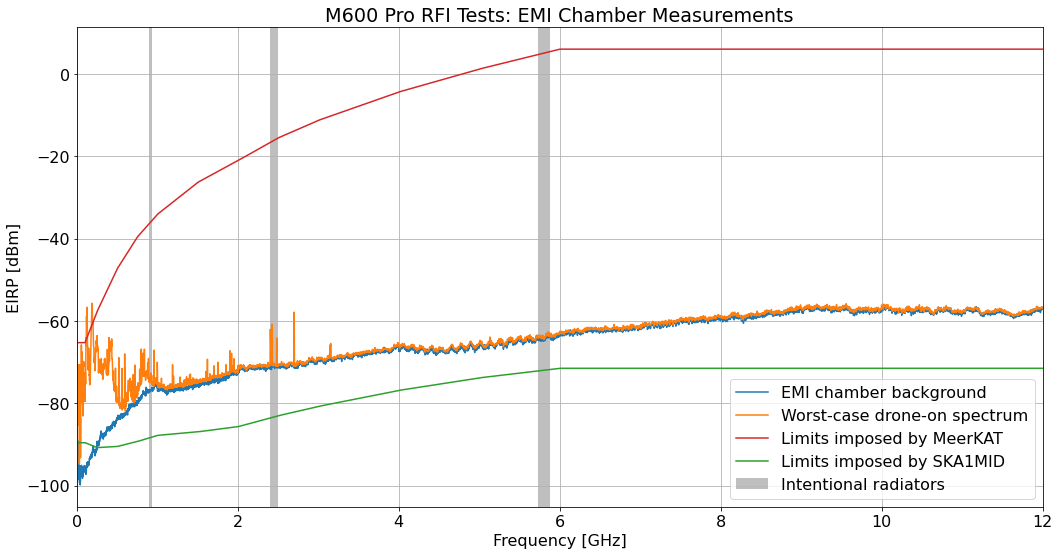

In [1053]:
f_lo = chamber["low"]["freqs"]
f_hi = chamber["high"]["freqs"]
f = np.concatenate((f_lo, f_hi))

worst_yaw = np.maximum(chamber['low']['yaw']['0'], np.maximum(chamber['low']['yaw']['60'], chamber['low']['yaw']['120'])) # the worst-case yaw
worst_horiz = np.maximum(np.maximum(chamber['low']['horiz']['0'], chamber['low']['horiz']['90']), np.maximum(chamber['low']['horiz']['180'], chamber['low']['horiz']['270'])) # the worst-case horizontal
worst_vert = np.maximum(np.maximum(np.maximum(chamber['low']['vert']['0'], chamber['low']['vert']['15']), np.maximum(chamber['low']['vert']['30'], chamber['low']['vert']['45'])), 
                        np.maximum(np.maximum(np.maximum(chamber['low']['vert']['60'], chamber['low']['vert']['180']), np.maximum(chamber['low']['vert']['90'], chamber['low']['vert']['-15'])), 
                                   np.maximum(np.maximum(chamber['low']['vert']['-30'], chamber['low']['vert']['-45']), np.maximum(chamber['low']['vert']['-60'], chamber['low']['vert']['-90'])))) # the worst-case vertical (oof)
worst_low = np.maximum(np.maximum(worst_yaw, worst_horiz), worst_vert)


worst_yaw = np.maximum(chamber['high']['yaw']['0'], np.maximum(chamber['high']['yaw']['60'], chamber['high']['yaw']['120'])) # the worst-case yaw
worst_horiz = np.maximum(chamber['high']['horiz']['0'], chamber['high']['horiz']['90']) # the worst-case horizontal
worst_vert = np.maximum(np.maximum(chamber['high']['vert']['0'], chamber['high']['vert']['180']), np.maximum(chamber['high']['vert']['90'], chamber['high']['vert']['-90']))
worst_high = np.maximum(np.maximum(worst_yaw, worst_horiz), worst_vert)


####
# get ready to convert the EMI chamber data to dBuV/m at 10m
####

# total cable loss (assuming all cables are used in all cases)
cableab_interp = np.interp(cablech6_freqs, cableab_freqs, cableab_mags)
cableac_interp = np.interp(cablech6_freqs, cableac_freqs, cableac_mags)
allcable_freqs = cablech6_freqs
allcable_mags = cablech6_mags + cableab_interp + cableac_interp

# convert the antenna gain to an antenna factor
lpda_af = 20.*np.log10(lpda_freqs) - lpda_mags - 29.7707
lpda_af = np.interp(f_lo, lpda_freqs, lpda_af)

horn_af = 20.*np.log10(horn_freqs) - horn_mags - 29.7707
horn_af = np.interp(f_hi, horn_freqs, horn_af)

# build a cable and amplifier gain correction
lo_cable_amp = -1.*np.interp(f_lo, allcable_freqs, allcable_mags) - np.interp(f_lo, amp1306e_freqs, amp1306e_mags)
hi_cable_amp = -1.*np.interp(f_hi, allcable_freqs, allcable_mags) - np.interp(f_hi, ampamf6d_freqs, ampamf6d_mags)

# make a big combined correction factor
chamber_corr = np.concatenate((lo_cable_amp, hi_cable_amp)) + np.concatenate((lpda_af, horn_af))

# correction to convert measured dBm to EIRP
dbm_to_eirp = chamber_corr + 19.13

# correction to convert measured dBm to dBuV/m at 3m
dbm_to_3m = chamber_corr + 114.36

# correction to convert measured dBm to dBuV/m at 10m
dbm_to_10m = chamber_corr + 103.9

####
# plot!
####

fig = plt.figure(figsize=(15,8))
fig.patch.set_facecolor('white')

plt.plot(f/1000., np.concatenate((chamber["low"]["bgnd"], chamber["high"]["bgnd"]))+dbm_to_eirp, label="EMI chamber background", color="tab:blue")
plt.plot(f/1000., np.concatenate((worst_low, worst_high))+dbm_to_eirp, label="Worst-case drone-on spectrum", color="tab:orange")

plt.plot(f/1000., np.interp(f, meerkat_freqs, meerkat_eirp_cont), label="Limits imposed by MeerKAT", color="tab:red")
plt.plot(f/1000., np.interp(f, ska1mid_freqs, ska1mid_eirp_cont), label="Limits imposed by SKA1MID", color="tab:green")
# plt.plot(f, np.interp(f, meerkat_freqs, meerkat_eirp_spec), color="tab:blue")
# plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_eirp_spec), color="tab:green")

ax = plt.gca()
ax.axvspan(.900, .928, facecolor='grey', alpha = 0.5, label="Intentional radiators")
ax.axvspan(2.4, 2.5, facecolor='grey', alpha = 0.5)
ax.axvspan(5.725, 5.875, facecolor='grey', alpha = 0.5)


plt.xlim(0,12)
plt.xlabel("Frequency [GHz]")
plt.ylabel("EIRP [dBm]")
plt.title("M600 Pro RFI Tests: EMI Chamber Measurements")
#plt.ylim(-100, -30)
#plt.semilogx()
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("./rfi_plots/chamber_all_combined.png")
plt.show()

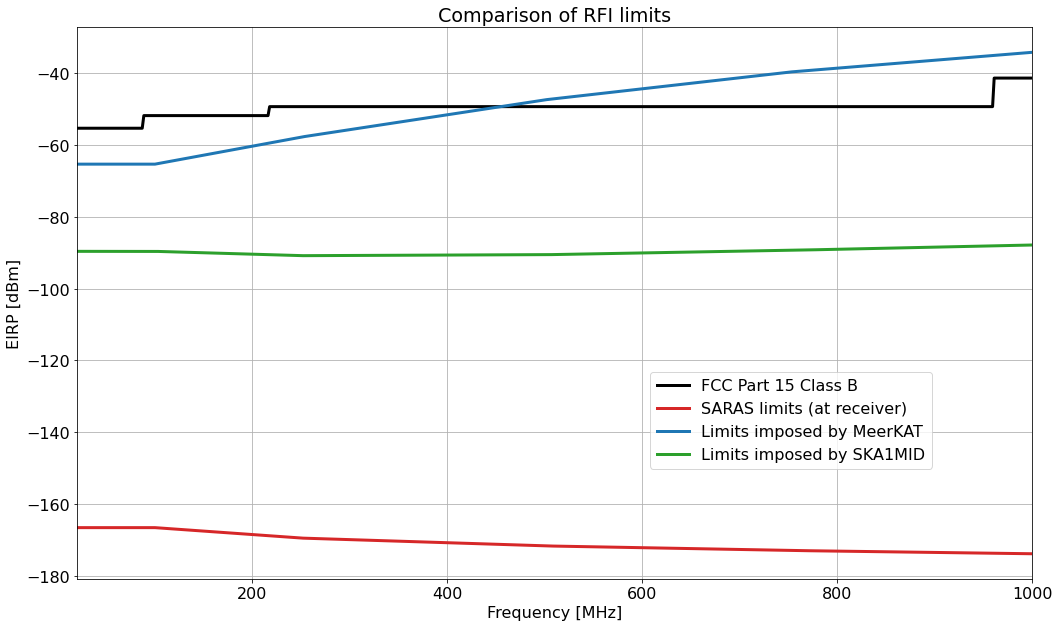

In [938]:
f = chamber["low"]["freqs"]

# f_lo = chamber["low"]["freqs"]
# f_hi = chamber["high"]["freqs"]
# f = np.concatenate((f_lo, f_hi))

####
# plot!
####

fig = plt.figure(figsize=(15,9))
fig.patch.set_facecolor('white')

plt.plot(f, np.interp(f, fccb_freqs, fccb_mags), color="black", label="FCC Part 15 Class B", linewidth=3)
plt.plot(f, np.interp(f, meerkat_freqs, meerkat_orig), label="SARAS limits (at receiver)", color="tab:red", linewidth=3)
plt.plot(f, np.interp(f, meerkat_freqs, meerkat_eirp_cont), label="Limits imposed by MeerKAT", color="tab:blue", linewidth=3)
plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_eirp_cont), label="Limits imposed by SKA1MID", color="tab:green", linewidth=3)
#plt.plot(f, np.interp(f, meerkat_freqs, meerkat_eirp_spec), color="tab:blue", linewidth=2)
#plt.plot(f, np.interp(f, ska1mid_freqs, ska1mid_eirp_spec), color="tab:green", linewidth=2)
#plt.plot(f, np.interp(f, meerkat_freqs, meerkat_orig)+15., color="tab:red", linewidth=2)

plt.xlim(20,1000)
plt.xlabel("Frequency [MHz]")
plt.ylabel("EIRP [dBm]")
plt.title("Comparison of RFI limits")
#plt.ylim(-100, -30)
#plt.semilogx()
plt.legend(loc=(0.6,0.2))
plt.grid()
plt.tight_layout()
plt.savefig("./rfi_plots/limit_lines.png")
plt.show()